# Introduction

This notebook is aimed to predict Airbnb data from the city of Malaga (Spain) using Regression models in Sklearn library. Data was obtained from Inside Airbnb website (http://insideairbnb.com/get-the-data.html). This small project is aimed to a first approach to Regression Models using Sklearn, as in most of my laboral experience in research, Regression Models were build  using SPSS software (IBM) or StatsModels.

To offer a general overview of the purpose of this notebook, we will: 

* Perform some data cleaning and data exploration. New features will be created in the process and added to the predictor variables.

* Explore the distribution of the predictor and target variables, applying data transformation when neccesary.

* A first feature selection for categorical data will be carried out running Analysis of Variance (ANOVA) before performing ordinal and dummy coding of these variables.

* Multicollinearity will be checked based on Variance Inflation Factor (VIF), removing features when the VIF is above the established threshold.

* After standardize the data, correlation analysis will be performed to have a general idea of significant predictors in the data. Predictors with a correlation values above 0.9 and also features with a high fraction of constant values will be removed.

* Multiple methods are applied for feature selection (F Regression, Random Forest, Recursive Feature Elimination with Lasso Regression, Backward Elimination and Stepwise Elimination). These different selected features will be saved and models will be fitted in order to compare model performance based on these.

* Finally, Lasso, Ridge, ElasticNet and Random Forest Regression models are meant to be build. Model performance will be evaluated on different metrics.

# Set environment
Import libraries and write settings here.

In [72]:
# data handling
import pandas as pd
import numpy as np
import pingouin as pg
from itertools import combinations

# visualization
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import FastMarkerCluster

# stats
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as multi
import statsmodels.stats as smstats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ml
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# warnings
import warnings
warnings.filterwarnings("ignore")

## Import data

In [73]:
listings = pd.read_csv('listings_detailed.csv')

## DataFrame first look

We can see that  we have 3 columns with only NaN values in the dataset: 'neighbourhood_group_cleansed', 'bathrooms' and 'calendar_updated'. Another column with mostly NaN values is 'host_neighbourhood'. We will drop these columns. Some missing values are also found in the columns concerning reviews, specifically in 'last_review' and 'reviews_per_month'

We will also remove the '$' sign the column 'price' and will transform it to numeric dtype.

Missing values will be visualized using the msno package.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5289 entries, 0 to 5288
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5289 non-null   int64  
 1   listing_url                                   5289 non-null   object 
 2   scrape_id                                     5289 non-null   int64  
 3   last_scraped                                  5289 non-null   object 
 4   name                                          5289 non-null   object 
 5   description                                   5285 non-null   object 
 6   neighborhood_overview                         2941 non-null   object 
 7   picture_url                                   5289 non-null   object 
 8   host_id                                       5289 non-null   int64  
 9   host_url                                      5289 non-null   o

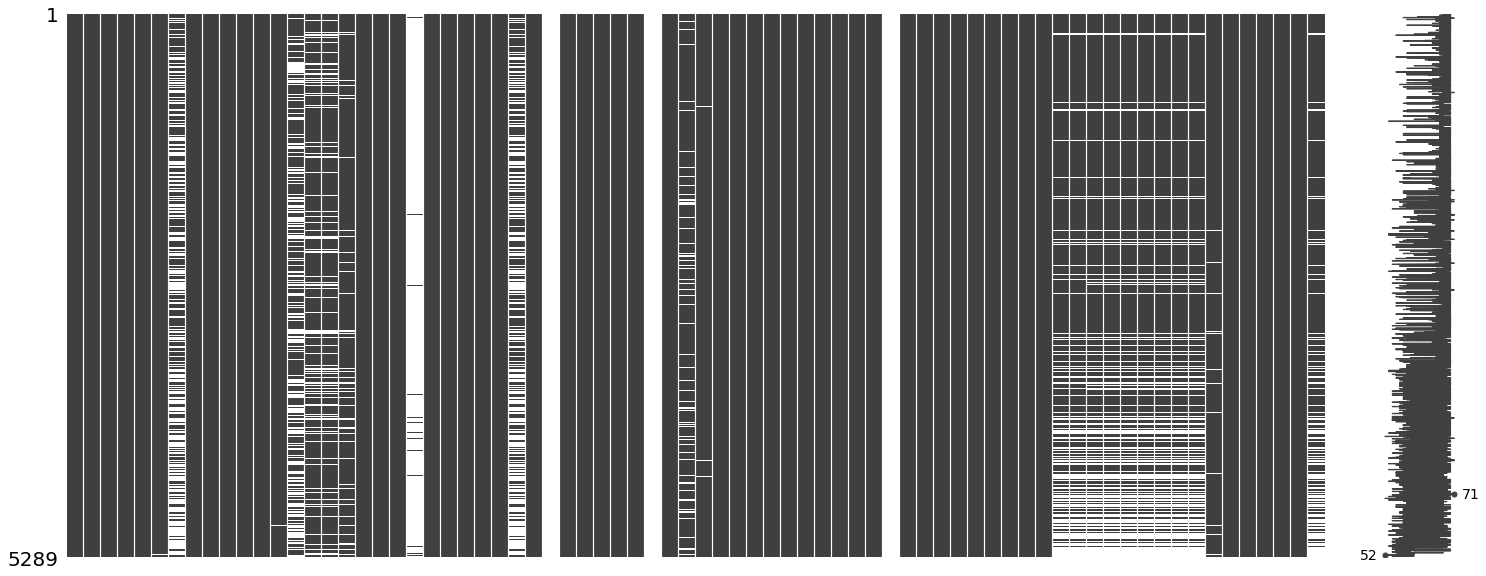

In [74]:
msno.matrix(listings)

# price contains string ($) so we will remove the dollar sign and force the conversion
listings['price'] = listings['price'].str.slice(start=1)

# force conversion
listings['price'] = listings['price'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
listings.info()

## Data cleaning

In light of 'bathrooms_text', we are going to create a new feature called 'bathroom_type' that will have a value 'shared' if the bathroom is shared with other people, otherwise 'no shared'. From the same column 'bathrooms_text', we will created a new ordinal column one called 'bathrooms', indicating the number of bathrooms available in the accomodation.

In [75]:
# masks
shared = listings['bathrooms_text'].str.contains('shared')
half_bath = listings['bathrooms_text'].str.contains('half-bath')

# apply masks for shared or not shared bathroom
listings['bathroom_type'] = 'no shared'
listings['bathrooms'] = ''
listings.loc[shared, 'bathroom_type'] = 'shared'
# extract numeric values for baths
listings['bathrooms'] = listings['bathrooms_text'].str.extract('(\d+(?:\.\d+)?)', expand=False)
# now get half-bath
listings.loc[half_bath, 'bathrooms'] = 0.5
# convert 'bathrooms' into numeric type
listings['bathrooms'] = listings['bathrooms'].apply(lambda x: pd.to_numeric(x, errors='coerce'))
# drop 'bathrooms_text'
listings.drop(columns='bathrooms_text', inplace=True)

listings[['bathroom_type', 'bathrooms']]

,bathroom_type,bathrooms
0,no shared,1.0
1,no shared,2.5
2,shared,2.0
3,shared,1.5
4,no shared,2.0
...,...,...
5284,no shared,1.0
5285,no shared,2.0
5286,no shared,2.0
5287,no shared,2.0


### First selection of variables

We are going to build our model to predict price based only on accomodation characteristics and website ratings. Based on this, we will drop variables that encode information about the host, keeping some of them for the moment as they will be useful soon.

We see that we have quite a few columns containing information about minimum and maximum nights. Let's explore these to check if they contain useful information. We can see that some of the columns contains the same information as 'minimum_nights' and 'maximum_nights'. We will keep it simple keeping only these two columns. 

We will drop 'neighbourhood' columns except 'neighbourhood_cleansed', as this last column contains the name of the different neighbourhoods of Málaga. Most of 'neighbourhood' columns contain a lot of missing values, so they will not be useful as imputation will be quite complicated to perform. We will also drop 'has availability' column at it only contains True values.

Finally, empty columns will be also dropped.

In [76]:
keep_cols = ['host_id', 'id', 'minimum_nights', 'maximum_nights', 'host_is_superhost']
host_cols = [col for col in listings.columns if 'host' in col if col not in keep_cols]
night_cols = [col for col in listings.columns if 'nights' in col if col not in keep_cols]
other_cols = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'description', 
              'picture_url', 'availability_30', 'availability_60', 'availability_90', 
              'first_review', 'last_review', 'license', 'number_of_reviews_ltm',
              'number_of_reviews_l30d', 'calendar_last_scraped', 'neighborhood_overview',
              'neighbourhood', 'has_availability', 'amenities']

# empty columns
mask_empty_cols = listings.isnull().sum() == len(listings)
empty_cols = listings.columns[mask_empty_cols].to_list()

# columns to drop
cols_drop = host_cols + other_cols + night_cols + empty_cols

# drop columns
listings.drop(columns=cols_drop, inplace=True)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5289 entries, 0 to 5288
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           5289 non-null   int64  
 1   host_id                      5289 non-null   int64  
 2   host_is_superhost            5289 non-null   object 
 3   neighbourhood_cleansed       5289 non-null   object 
 4   latitude                     5289 non-null   float64
 5   longitude                    5289 non-null   float64
 6   property_type                5289 non-null   object 
 7   room_type                    5289 non-null   object 
 8   accommodates                 5289 non-null   int64  
 9   bathrooms                    5287 non-null   float64
 10  bedrooms                     4853 non-null   float64
 11  beds                         5266 non-null   float64
 12  price                        5271 non-null   float64
 13  minimum_nights    

## New features

We will create a new feature that entails the size of each accomodation based on the number of people the house/flat can accomodates. We will differentiate between small (3 of less people), medium (between 4 and 7 people) and large (between 8 and 20 people)

In [77]:
size_1 = (listings['accommodates'] <= 3)
size_2 = (listings['accommodates'] >= 4) & (listings['accommodates'] <= 7)
size_3 = (listings['accommodates'] >= 8) & (listings['accommodates'] <= 20)

listings['size'] = ''
listings.loc[size_1, 'size'] = 'small'
listings.loc[size_2, 'size'] = 'medium'
listings.loc[size_3, 'size'] = 'large'

listings['size']

0        small
1       medium
2        small
3        small
4        large
         ...  
5284    medium
5285    medium
5286    medium
5287    medium
5288    medium
Name: size, Length: 5289, dtype: object

## Define X and y

In [78]:
X = listings.drop(columns='price')
y = listings['price']

# Train-test split

70-30 train-test split

In [79]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.3, random_state=42)

print('X train and test sets shapes: ' + str(train_X.shape), str(test_X.shape), 
      '\ny train and test sets shapes: ' + str(train_y.shape), str(test_y.shape))

# reset index for further preprocessing
train_X.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
test_X.reset_index(drop=True, inplace=True)
test_y.reset_index(drop=True, inplace=True)

X train and test sets shapes: (3702, 27) (1587, 27) 
y train and test sets shapes: (3702,) (1587,)


## Impute data

We also see that we have some missing values in review variables, bedrooms, beds and price, so we will impute these missing data with the mean.

In [80]:
series = train_X.isnull().sum().sort_values(ascending=False)
list_miss = series[series > 0].index.to_list()
list_miss

['review_scores_accuracy',
 'review_scores_value',
 'review_scores_location',
 'review_scores_communication',
 'review_scores_checkin',
 'review_scores_cleanliness',
 'review_scores_rating',
 'reviews_per_month',
 'bedrooms',
 'beds',
 'bathrooms']

We are going to transform out DataFrame into a Numpy array to impute the data. We will use SimpleImputer, with the data imputation taking place only for columns with missing data using the mean. Afterwards, we will check that non-missing values are left in the DataFrame.

In [81]:
# to Numpy
to_impute = train_X[list_miss].to_numpy()
# SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# to DataFrame
imputed = pd.DataFrame(data=imp.fit_transform(to_impute), columns=list_miss)
# concatenate the imputed columns to the rest of the DataFrame
train_X = pd.concat([train_X.drop(columns=list_miss), imputed], axis=1)
# check for missing values
train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3702 entries, 0 to 3701
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           3702 non-null   int64  
 1   host_id                      3702 non-null   int64  
 2   host_is_superhost            3702 non-null   object 
 3   neighbourhood_cleansed       3702 non-null   object 
 4   latitude                     3702 non-null   float64
 5   longitude                    3702 non-null   float64
 6   property_type                3702 non-null   object 
 7   room_type                    3702 non-null   object 
 8   accommodates                 3702 non-null   int64  
 9   minimum_nights               3702 non-null   int64  
 10  maximum_nights               3702 non-null   int64  
 11  availability_365             3702 non-null   int64  
 12  number_of_reviews            3702 non-null   int64  
 13  instant_bookable  

We are also going to impute data with the mean for the train_y dataset.

In [82]:
# to Numpy
to_impute = train_y.values.reshape(-1, 1)
# SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# to DataFrame
train_y = pd.Series(data=imp.fit_transform(to_impute).flatten(), name='price')
train_y

0        70.0
1        81.0
2       100.0
3        44.0
4       350.0
        ...  
3697    100.0
3698    379.0
3699     70.0
3700     17.0
3701    107.0
Name: price, Length: 3702, dtype: float64

# Exploratory data analysis (EDA)

Let's print the head of 'listings' to see what king of information each column is offering us.

In [83]:
display(train_X.head())

,id,host_id,host_is_superhost,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,minimum_nights,...,review_scores_value,review_scores_location,review_scores_communication,review_scores_checkin,review_scores_cleanliness,review_scores_rating,reviews_per_month,bedrooms,beds,bathrooms
0,44473122,5890675,f,Centro,36.72602,-4.42028,Entire apartment,Entire home/apt,8,1,...,9.231478,9.573916,9.656197,9.664391,9.409355,92.503926,1.212589,4.0,6.0,2.0
1,12237883,65859107,f,Este,36.71792,-4.34880,Entire apartment,Entire home/apt,6,3,...,9.000000,10.000000,10.000000,10.000000,10.000000,92.000000,0.310000,3.0,5.0,1.0
2,41581326,285578671,f,Centro,36.71084,-4.42777,Entire apartment,Entire home/apt,6,1,...,6.000000,8.000000,8.000000,8.000000,8.000000,60.000000,0.130000,3.0,6.0,2.0
3,33867887,152016953,f,Centro,36.72371,-4.42494,Entire apartment,Entire home/apt,3,1,...,8.000000,10.000000,10.000000,10.000000,9.000000,100.000000,0.120000,1.0,2.0,1.0
4,38613265,281413604,f,Centro,36.72428,-4.41632,Entire apartment,Entire home/apt,16,1,...,9.231478,9.573916,9.656197,9.664391,9.409355,92.503926,1.212589,7.0,16.0,2.0


Is it possible that each Airbnb room/flat have a different 'id'? or maybe this would be addressed by 'host_id'? Let's explore this!

We can see that 'id' has the same length as the DataFrame. Therefore, 'Id' is giving us a different id for each Airbnb accomodation. On the other hand, Host id has a unique id for each host, so if a host has 3 accomodations offered in the platform, they will be registered under the same host id.

We can also see that the three hosts in the top 3 with the highest number of Airbnb accomodations have 218, 66 and 65 places offered respectively!

In [84]:
print('Size of unique Id details: \n' + str(len(train_X['id'].value_counts())))
print('\nSize of unique host id details: \n' + str(len(train_X['host_id'].value_counts())))
print('\nHosts with the highest number of Airbnb accomodations offered: \n')
no_accomodations_per_host = train_X.groupby(['host_id']).agg({'id': 'count'}).reset_index(drop=False)
no_accomodations_per_host.rename(columns={'id': 'n_accomodations'}, inplace=True)
display(no_accomodations_per_host.sort_values(by='n_accomodations', ascending=False).head())

Size of unique Id details: 
3702

Size of unique host id details: 
1807

Hosts with the highest number of Airbnb accomodations offered: 



,host_id,n_accomodations
797,80225433,157
948,115528688,44
104,5890675,44
866,94173177,43
1012,126429738,42


## Accomodations map

First, let's create a map to visualize the number of hosts in the city of Málaga.

Let's extract the information of the location of each Airbnb host. In the listings DataFrame we have one column for the latitude and another for the longitude. We will zip both to use it in the interactive map.

We will locate the map in the following latitude and longitude, following data found in the web concerning the location of Málaga: (36.72016, -4.42034)

We can see in the map that most of the Airbnb hosts are located in the city of Malaga, while some place are found in the surrounding areas.

In [85]:
latitude = train_X['latitude'].tolist()
longitude = train_X['longitude'].tolist()
location_info = list(zip(latitude, longitude))

map_malaga = folium.Map(location=[36.72016, -4.42034],
                        zoom_start=12,
                        tiles='cartodbpositron')
FastMarkerCluster(location_info).add_to(map_malaga)
map_malaga

## Accomodations per neighbourhood

Let's explore then the number of accomodations offered by each neighbourhood in Málaga.

We can see that Málaga Centro has the highest number of accomodations with 3591! This could be expected, as all tourist who do not know the city would like to have an accomodation in the city centre. This neighbourhood is followed by Este with 578, an area with well-known beaches. Finally, Carretera de Cádiz with 449 is another neighbourhood next to the coast, but away from the touristic area.

,neighbourhood_cleansed,id
0,Centro,2518
1,Este,404
2,Carretera de Cadiz,315
3,Cruz De Humilladero,161
4,Bailen-Miraflores,88
5,Churriana,70
6,Teatinos-Universidad,50
7,Ciudad Jardin,37
8,Palma-Palmilla,26
9,Campanillas,18


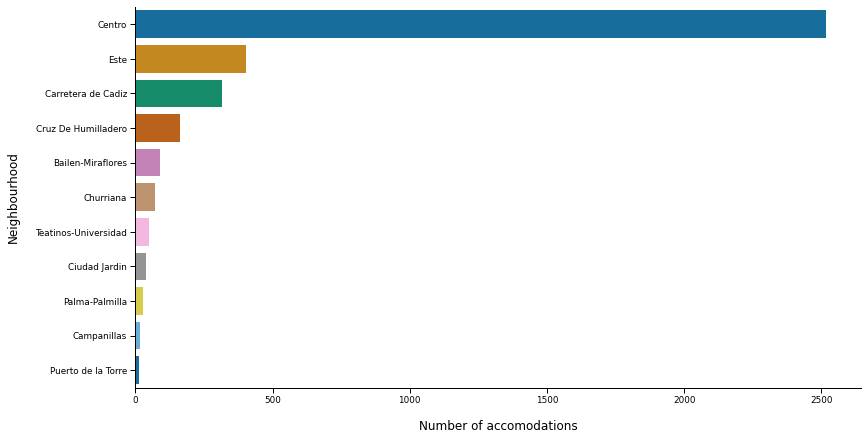

In [86]:
accomodations_per_neighbourhood = train_X.groupby(['neighbourhood_cleansed'])['id'].count().sort_values(ascending=False).reset_index()
display(accomodations_per_neighbourhood)

# plot
sns.set_context('paper')
ax, fig = plt.subplots(figsize=(13, 7))
sns.barplot(x='id', y='neighbourhood_cleansed', data=accomodations_per_neighbourhood, orient='h', palette='colorblind')
plt.xlabel(xlabel='Number of accomodations', labelpad=15, fontsize=12)
plt.ylabel(ylabel='Neighbourhood', labelpad=15, fontsize=12)
sns.despine()

## Type of accomodation per neighbourhood

It will be quite interesting to know the type of accomodation that is offered in each neighbourhood, or if it is a tendency in some of them to offer certain type of rooms. We could hypothesize that accomodations in Málaga Centro will be more 'private room' oriented, whereas in surrounding areas it could be possible to find more 'entire appartment' accomodations.

Contrary to our expectations, most of the accomodations offered in Málaga Centro are entire appartment, which could also be expected as most of tourist would like to have an entire accomodation for themselves. 'Private room' accomodations could be more common in surrounding areas, away from the city centre were most of the population live.

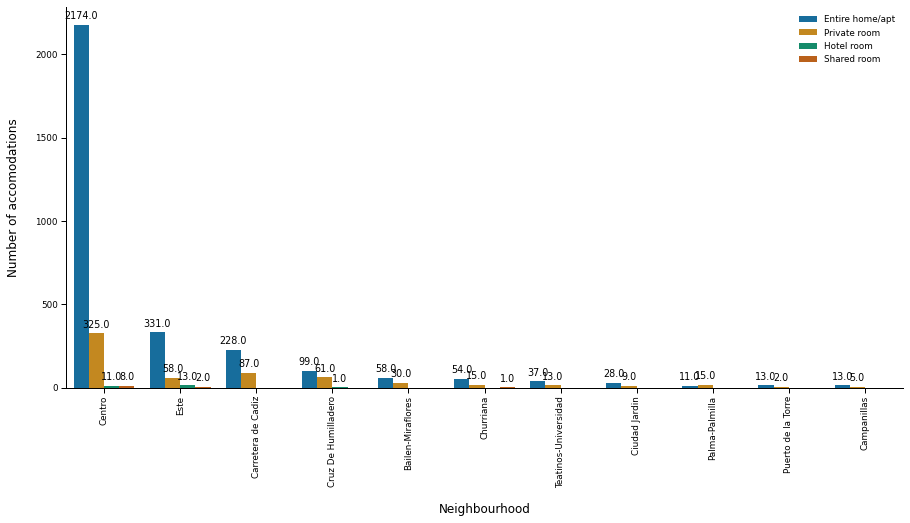

In [87]:
accomodations_per_neighbourhood_type = train_X.groupby(['neighbourhood_cleansed', 'room_type'])['id'].count().sort_values(ascending=False).reset_index()

# plot
sns.set_context('paper')
fig, ax = plt.subplots(figsize=(15, 7))
g = sns.barplot(x='neighbourhood_cleansed', y='id', data=accomodations_per_neighbourhood_type, hue='room_type', orient='v', palette='colorblind')
for note in g.patches:
    g.annotate(format(note.get_height(), '.1f'), (note.get_x() + note.get_width() / 2., note.get_height()), 
               ha='center', va='center', xytext=(0, 9), textcoords='offset points')
plt.xlabel(xlabel='Neighbourhood', labelpad=15, fontsize=12)
plt.ylabel(ylabel='Number of accomodations', labelpad=15, fontsize=12)
plt.legend(loc='upper right', frameon=False)
plt.xticks(rotation=90)
sns.despine()

## Price per neighbourhood and type of room

Now, let's see the the price per night in each neighbourhood and type of room. 

We have spotted some high values in the sample with a low frequency above 800€. Although this could be variabily in the sample, we will explore this values to see if they are detected as possible outliers. We will use Tukey IQR and also KDE in Sklearn. In research, a common criteria is to remove those values that are 2 standard deviations above or below the mean, however, this criteria assumes a normal distribution of the data. I prefer to use non-parametric methods for this.

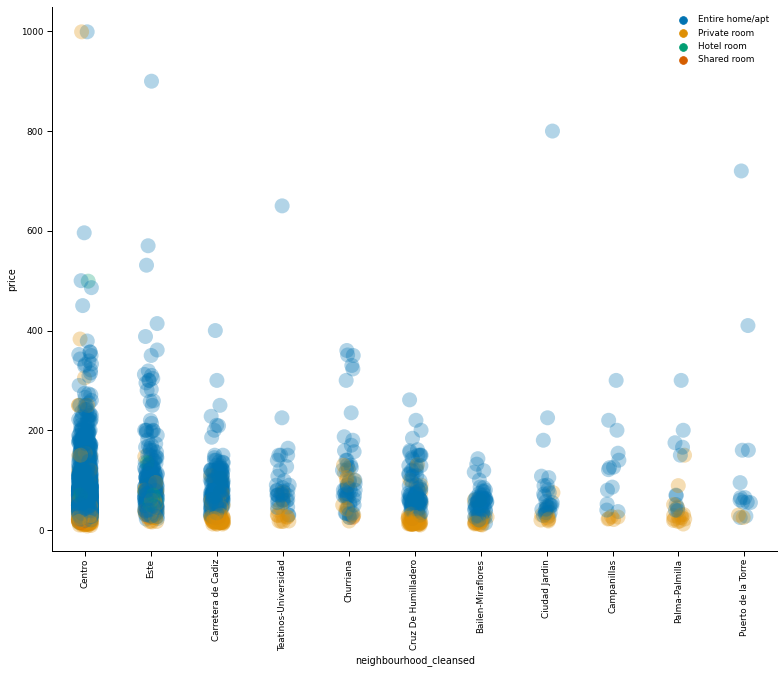

In [88]:
fig, ax = plt.subplots(figsize=(13, 10))
sns.stripplot(x=train_X['neighbourhood_cleansed'], y=train_y, palette='colorblind', 
              hue=train_X['room_type'], size=15, alpha=.3)
plt.legend(frameon=False)
plt.xticks(rotation=90)
sns.despine()

## Outliers
We see in the data some  values quite high compared to rest of the distibution. We will compute the IQR to identify these values as outliers or not.

In [89]:
def iqr(X_data, y_data):
    """
    Compute Tukey's Interquantile Range (IQR). Prints
    the computes IQR, lower and upper limit as well as 
    the number of outliers in the data.
    
    Input:
        dv: numeric variable as a pandas Series.
    Output:
        outlier: value of the outlier in the dv.
        outlier_loc: index of the outlier.
    """
    
    Q1, Q3 = np.percentile(y_data, [25, 75])
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR 
    upper_limit = Q3 + 1.5 * IQR 
    
    # store outliers and its location in the df
    outlier = []
    outlier_loc = []
    for i, x in enumerate(y_data): 
        if ((x > upper_limit) or (x < lower_limit)): 
            outlier.append(x)
            outlier_loc.append(i)
            
    print('IQR is: ' + str(IQR) + ' with a lower limit: ' + str(lower_limit) + ' and a upper limit: ' + str(upper_limit) + '\n' +
          'In general we have: ' + str(len(outlier)) + ' outliers in the dataset')
    
    # remove outliers
    X_data.drop(index=outlier_loc, inplace=True)
    X_data.reset_index(drop=True, inplace=True)
    y_data.drop(index=outlier_loc, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    
    return X_data, y_data

Let's remove these outliers from X and y and plot the distribution of prices per neighbourhood again. 

Note: we have fit the regression models with and without these outliers and there is not any difference in the scores. We will remove this data points unless we can also consider them as variability in the data. Although outlier removal should be treated carefully in small datasets.

IQR is: 43.75 with a lower limit: -24.625 and a upper limit: 150.375
In general we have: 234 outliers in the dataset


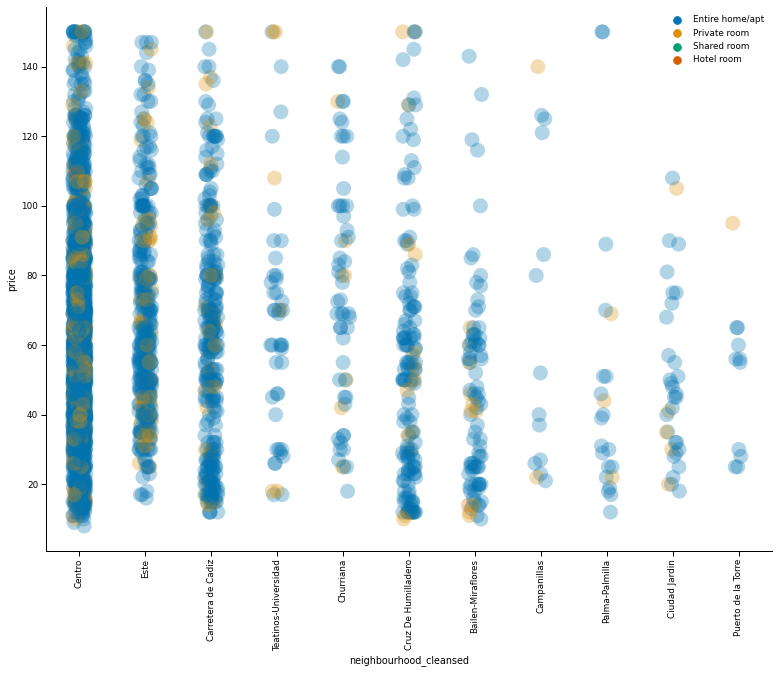

In [90]:
train_X, train_y = iqr(train_X, train_y)

# plot
fig, ax = plt.subplots(figsize=(13, 10))
sns.stripplot(x=train_X['neighbourhood_cleansed'], y=train_y, palette='colorblind', hue=X['room_type'], size=15, alpha=.3)
plt.legend(frameon=False)
plt.xticks(rotation=90)
sns.despine()

## Prices map

Now that we have fixed explored outliers concerning prices, let's plot a scatter plot based on the locations of each accomodation, and using the price as a hue marker. Oh! What a pity... not much difference is reflected in the scatter plot, so maybe it will be more convenient to create custom ranges of prices, for example, based on quantiles.

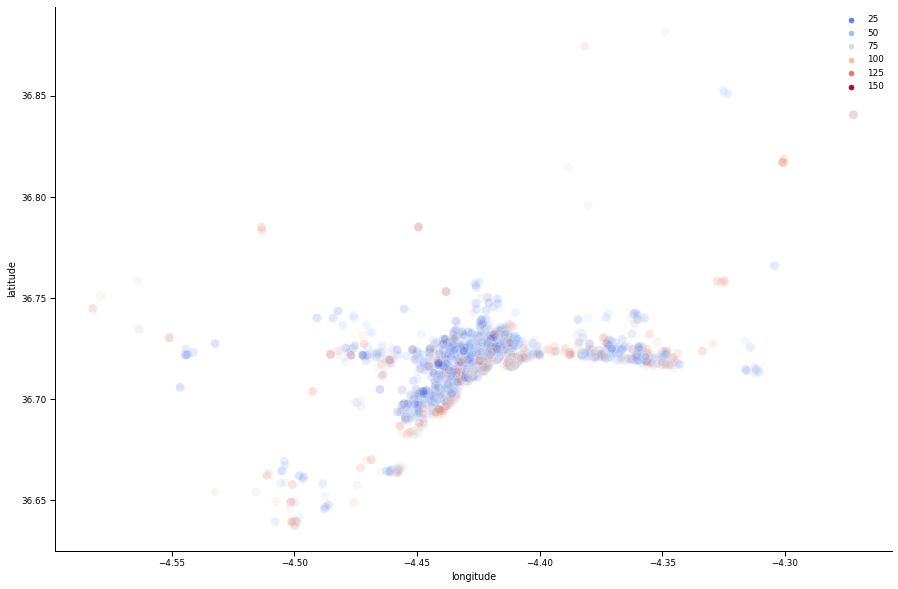

In [91]:
ax, fig = plt.subplots(figsize=(15, 10))
ax = sns.scatterplot(x='longitude', y='latitude', data=train_X, hue=train_y, palette='coolwarm', alpha=.2, s=80)
plt.legend(frameon=False)
sns.despine()

When we create out own ranges of prices based on percentiles, we can see a clear distinction of prices. As you go next to the coast the prices increase. This is quite normal, as people will be more willing to pay more just to be next to the beach, while most of the cheapest accomodations are in the interior part of the city. However, we find, some exceptions in the mountains. This could be related to bigger houses in the interior part of the province, that are often rented by big groups of people to spend a relaxed holidays.

It is interesting that most of the accomodations offered in Churriana are quite expensive. We know that Málaga-Costa del Sol airport is in that area, so it could be possible that these range of prices are due to this. 

It would be interesting to check if the size of the accomodation is related to its location, for that, we can use 'bedrooms' or 'property_type' columns from listings_details.

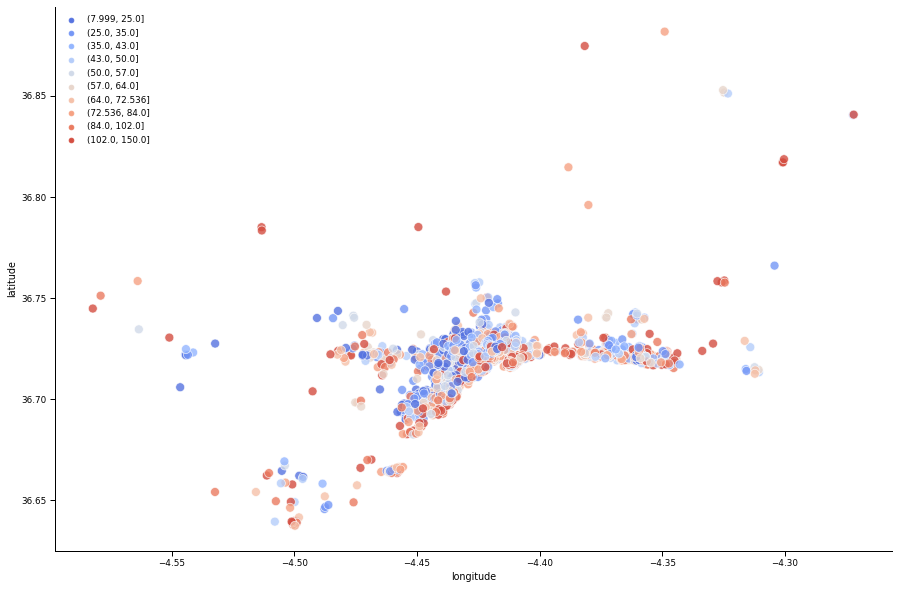

In [92]:
train_X['prices_percentiles'] = pd.qcut(x=train_y, q=10)
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x='longitude', y='latitude', data=train_X, hue='prices_percentiles', palette='coolwarm', alpha=.8, s=80)
plt.legend(frameon=False)
sns.despine()

## Type of room map

This map is quite interesting. We can see that cose to the coast, most of the offered accomodations seem to be entire apartments, while you go the interior part of the city you can find private rooms most likely. This is quite expected, as the main attraction of Málaga is it's sunny beaches, and of course, most of the tourist would like to be next to the see enjoying the sun.

This distribution can also give us a hint about rental problems in touristic cities. We see how the majority of flats offered next to the coast are entire accomodations, whereas next to the city center we find more private rooms.

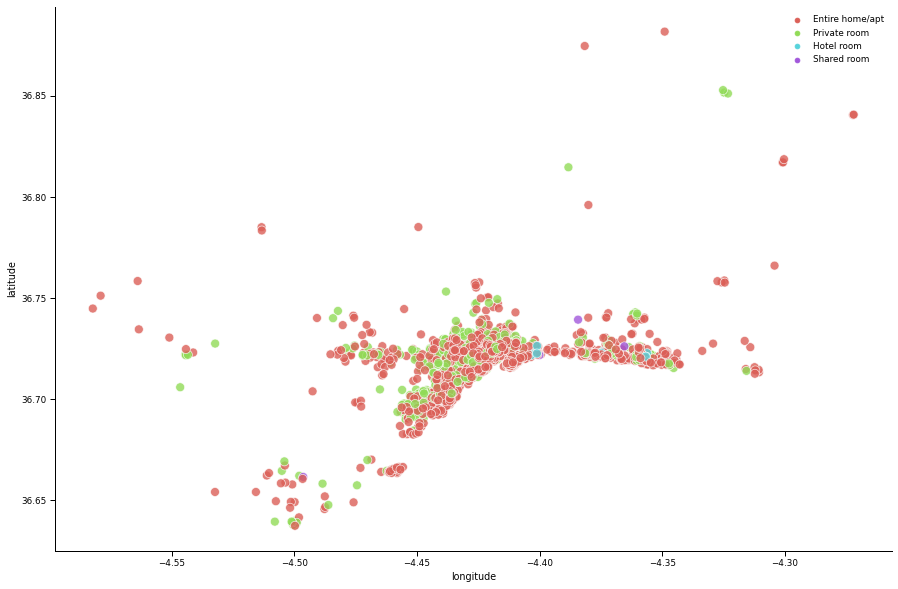

In [93]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x='longitude', y='latitude', data=train_X, hue='room_type', palette='hls', alpha=.8, s=80)
plt.legend(frameon=False)
sns.despine()

## Size per neighbourhood

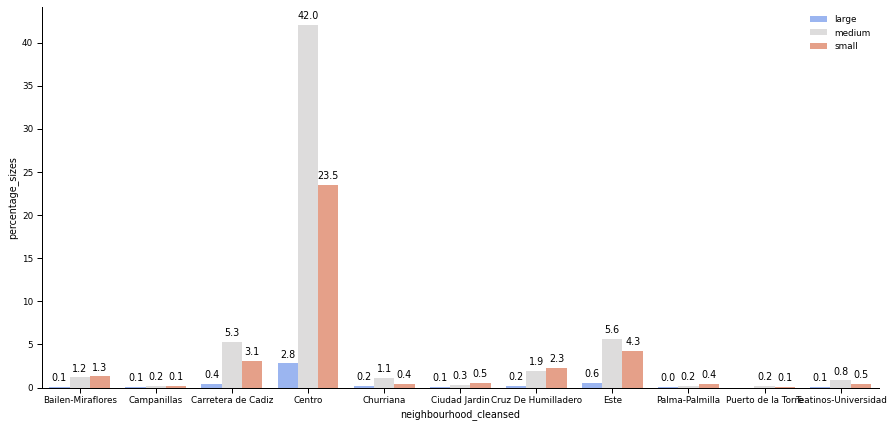

In [94]:
perc_sizes_neighbourhood = train_X.groupby(['neighbourhood_cleansed', 'size']).agg({'id': 'count'}).reset_index()
perc_sizes_neighbourhood['percentage_sizes'] = perc_sizes_neighbourhood.groupby(['neighbourhood_cleansed', 'size'])['id'].apply(lambda x: x * 100 / sum(perc_sizes_neighbourhood['id']))

fig, ax = plt.subplots(figsize=(15, 7))
g = sns.barplot(x='neighbourhood_cleansed', y='percentage_sizes', data=perc_sizes_neighbourhood, hue='size', orient='v', palette='coolwarm')
for note in g.patches:
    g.annotate(format(note.get_height(), '.1f'), (note.get_x() + note.get_width() / 2., note.get_height()), 
               ha='center', va='center', xytext=(0,9), textcoords='offset points')
plt.legend(frameon=False)
sns.despine()

## Size of room and prices map

By this plot we can confirm that most of the accomodations far away from the city are medium and large sizes, so it is possible that these are appartaments mostly rented by groups.

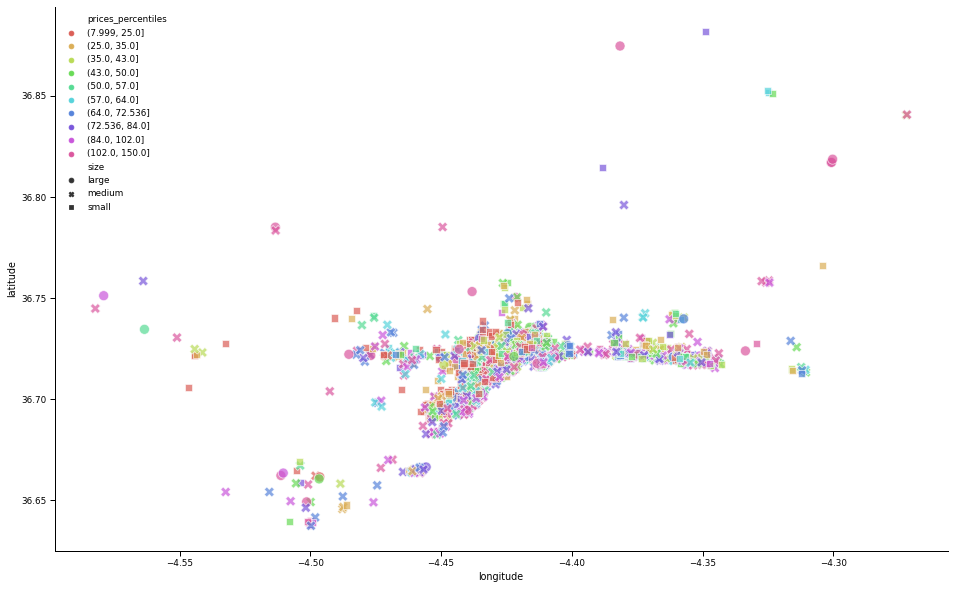

In [95]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(x='longitude', y='latitude', data=train_X, hue='prices_percentiles', style='size', palette='hls', alpha=.7, s=100)
plt.legend(frameon=False)
sns.despine()

## Superhost map

It seems that be a superhost is quite difficult, as we only have a few cases. We can also see that they are not distributed equally around the city.

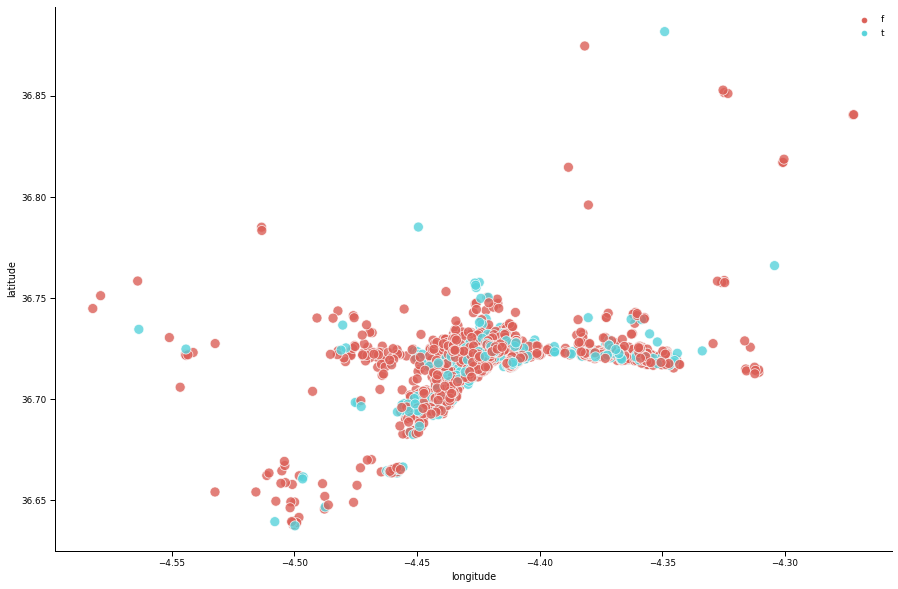

In [96]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x='longitude', y='latitude', data=train_X, hue='host_is_superhost', palette='hls', alpha=.8,s=100)
plt.legend(frameon=False)
sns.despine()

## Percentage of accomodations per size

Then, the majority of rooms offered in Airbnb Málaga are medium (58.40) and small size (33.94), whereas large rooms only represent 7.66% of the total of accomodations.

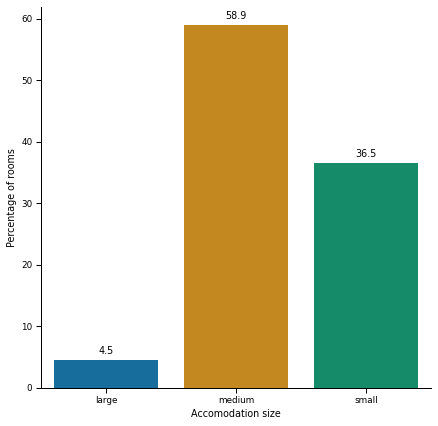

In [97]:
cases_size = train_X.groupby(['size']).agg({'id': 'count'}).reset_index()
cases_size['percentage_cases_size'] = cases_size['id'] * 100 / sum(cases_size['id'])

sns.set_context('paper')
fig, ax = plt.subplots(figsize=(7, 7))
g = sns.barplot(x='size', y='percentage_cases_size', data=cases_size, orient='v', palette='colorblind')
for note in g.patches:
    g.annotate(format(note.get_height(), '.1f'), (note.get_x() + note.get_width() / 2., note.get_height()), 
               ha='center', va='center', xytext=(0,9), textcoords='offset points')
plt.xlabel('Accomodation size')
plt.ylabel('Percentage of rooms')
sns.despine()

## Percentage of accomodations per size and price group

We can see from this plot that the majority of large accomodations fall in the range between 92€ and 999€ per night, whereas the small accomodations are mostly in the range between 8€ and 50€ per night. The medium size accomodations are more balanced between differences ranges of prices.

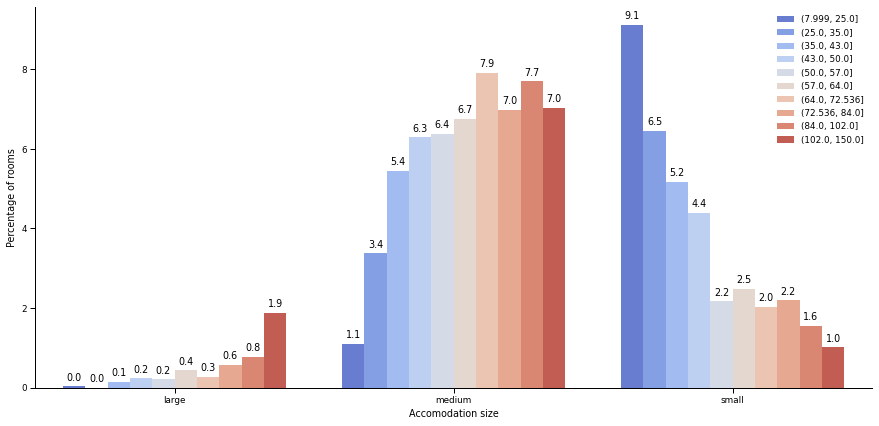

In [98]:
cases = train_X.groupby(['prices_percentiles', 'size']).agg({'id': 'count'}).reset_index()
cases['percentage_cases'] = cases.groupby(['prices_percentiles', 'size'])['id'].apply(lambda x: x * 100 / sum(cases['id']))

fig, ax = plt.subplots(figsize=(15, 7))
g = sns.barplot(x='size', y='percentage_cases', data=cases, hue='prices_percentiles', orient='v', palette='coolwarm')
for note in g.patches:
    g.annotate(format(note.get_height(), '.1f'), (note.get_x() + note.get_width() / 2., note.get_height()), 
               ha='center', va='center', xytext=(0,9), textcoords='offset points')
plt.xlabel('Accomodation size')
plt.ylabel('Percentage of rooms')
plt.legend(frameon=False)
sns.despine()

# Data distribution

## Explore categorical variables

### Number of categories per categorical variable

As we have categorical variables, we will extract the unique values of that variable into a list, an explore the number of categories in each one of them.

In [99]:
categorical_cols = train_X.select_dtypes(['object']).columns.to_list()

for col in categorical_cols:
    list_cat = train_X[col].unique().tolist()
    print('We have ' + str(len(list_cat)) + ' categories in ' + col)

We have 2 categories in host_is_superhost
We have 11 categories in neighbourhood_cleansed
We have 46 categories in property_type
We have 4 categories in room_type
We have 2 categories in instant_bookable
We have 2 categories in bathroom_type
We have 3 categories in size


There is one category that stand out on the number of categories. Property type has 51 different categories. We are going to show the different values and see if we can create a new feature in order to reduce the number of possible categories. If there is a lot of values inside low frequency categories, we can introduce these into a general one called 'others' and leave the main categories with most of the cases untouched.

Let's check how many categories do we have with less than 20 cases. In the first plot we can see that we have a lot of categories with a low frequency. In the second plot, we have plotted those categories with 20 or more cases. In general we can see that the more frequent categories tend to be 'entire' or 'private room'. Also in the low frequency values we find this cases. So the best option will be to drop this category and only keep 'room type' as it reports this information in just 4 categories.

Also, do not have a deep knowledge about Airbnb data, it will be better to keep prebuild categories.

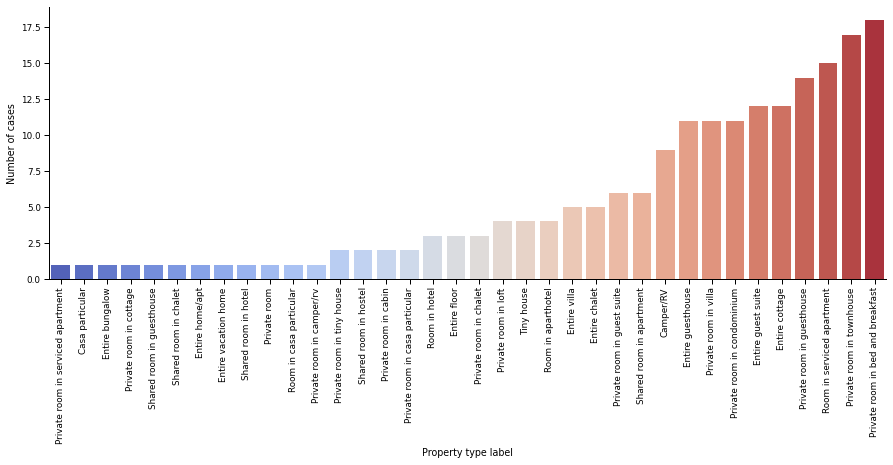

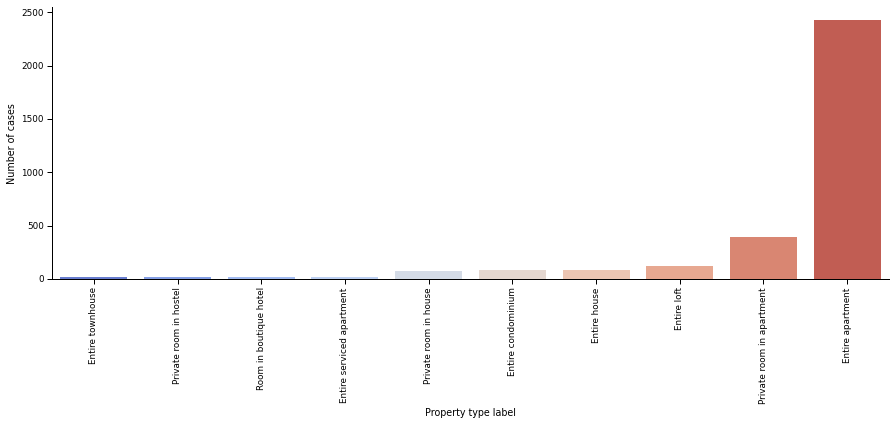

In [100]:
cases_size = train_X.groupby(['property_type']).agg({'id': 'count'}).reset_index()
cases_size.rename(columns={'id': 'no_cases'}, inplace=True)

low_freq_prop_type = cases_size[cases_size['no_cases'] < 20].sort_values(by='no_cases', ascending=True)
high_freq_prop_type = cases_size[cases_size['no_cases'] >= 20].sort_values(by='no_cases', ascending=True)
freq = [low_freq_prop_type, high_freq_prop_type]

for frequency in freq:
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.barplot(x='property_type', y='no_cases', data=frequency, palette='coolwarm')
    plt.xticks(rotation=90)
    plt.xlabel('Property type label')
    plt.ylabel('Number of cases')
    sns.despine()

### Drop not neccessary variables

As we have explained, we are going to drop 'property_type'. Also, we are going to drop 'id' and 'host_id' as they were only neccesary during EDA analysis.

In [101]:
train_X = train_X.drop(columns=['property_type', 'id', 'host_id', 'prices_percentiles'])

## Explore the distribution of numerical variables

Okay, phew! Now that we have finished with categorical variables, let's explore the distribution of numeric variables in our dataset.

In [102]:
def plot_dist(df, dv_list=None, transformation=None):
    """
    Plot distribution of data. If required, a transformation
    of the data could be applied.
    
    Input:
        df: DataFrame
        dv_list: list of variables to be plotted.
        trasnformation (numpy): transformation that wants
                                to be applied to the data.
    Output:
        Distribution plot and probability plot of each variable.
    """
    
    
    if dv_list == None:
        
        if transformation != None:
            df = df.apply(transformation)
        else:
            df = df
        
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(df, fit=norm, color='indianred', ax=ax[0])
        stats.probplot(df.dropna(), plot=ax[1])
        plt.show()
        
    elif dv_list != None:
        
        if transformation != None:
            df = df.apply(transformation)
        else:
            df = df
            
        for dv in dv_list:
            fig, ax = plt.subplots(1, 2, figsize=(15,5))
            sns.distplot(df[dv], fit=norm, color='indianred', ax=ax[0])
            stats.probplot(df[dv].dropna(), plot=ax[1])
            plt.show()

So from the distribution we can see that longitude have a normal distribution. Latitute could be considered normally distributed, but it has a left skew. And obviously the rest of variables (accomodates, bedrooms and beds) are not normally distributed. So we will apply Spearman method for correlation in order to do a first selection of features.

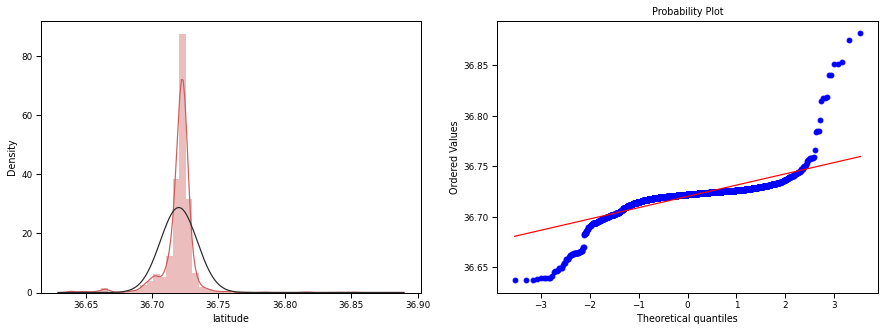

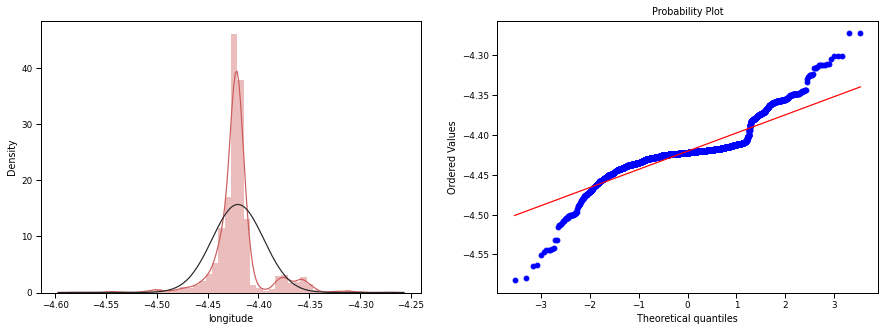

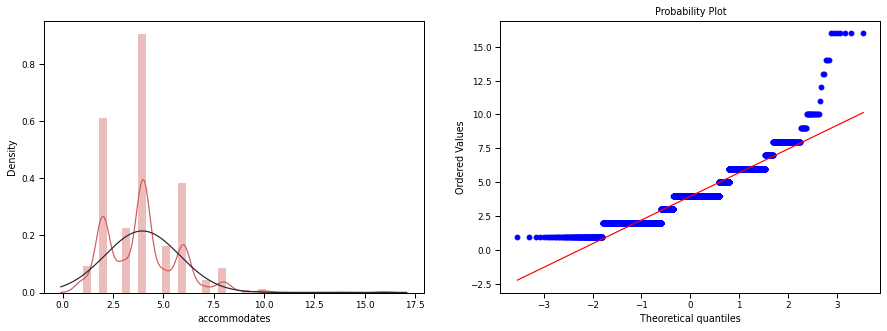

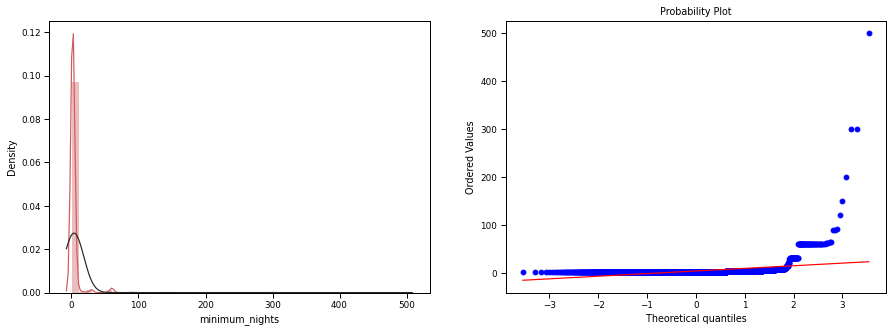

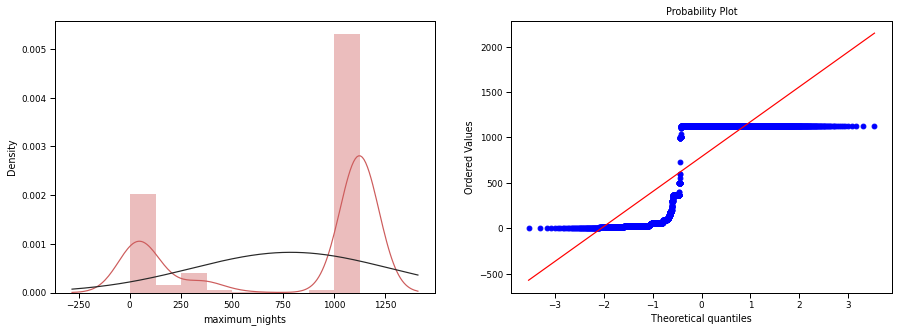

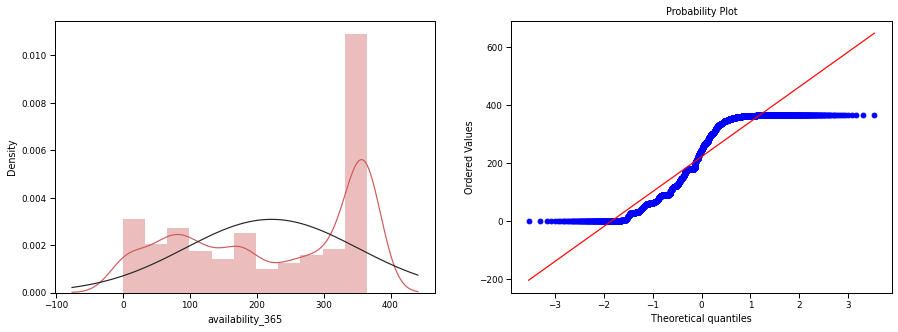

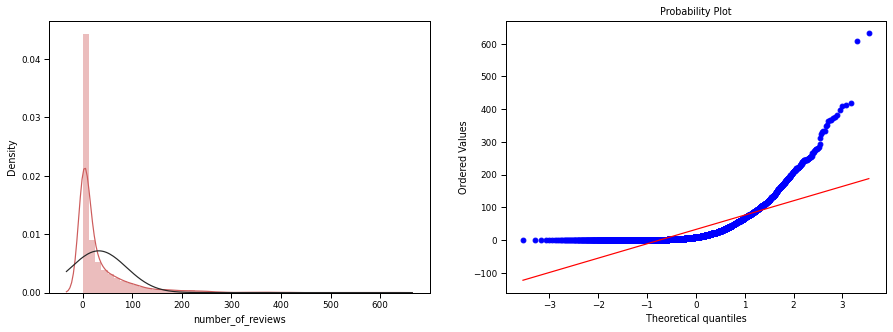

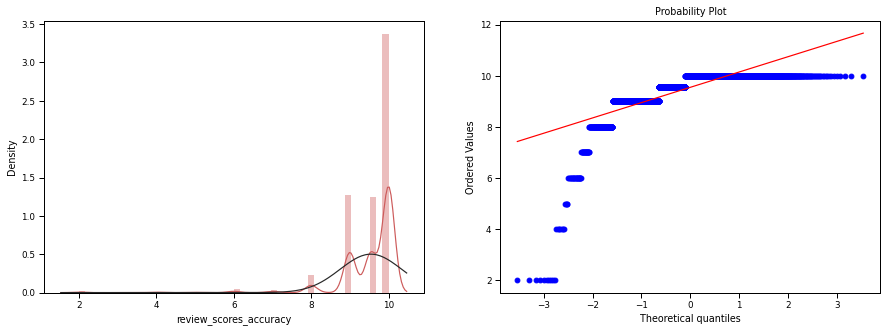

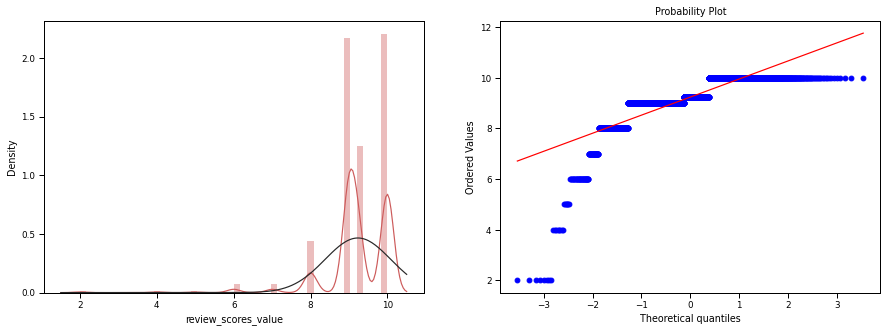

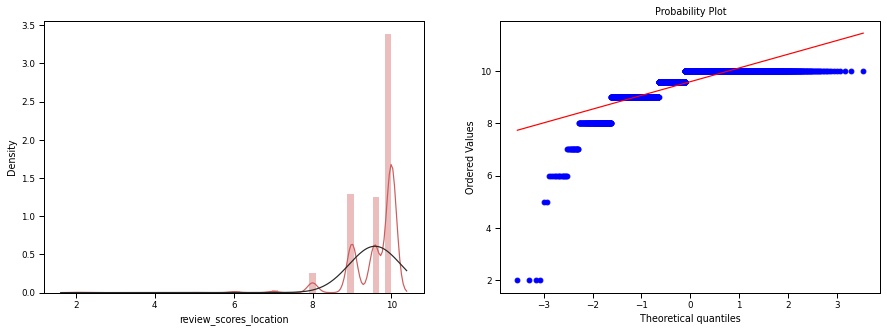

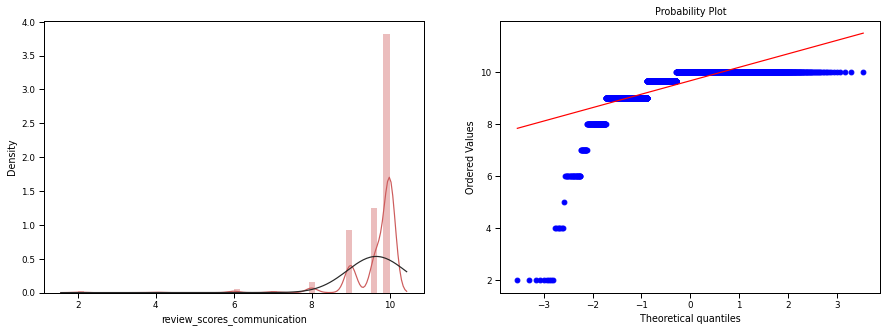

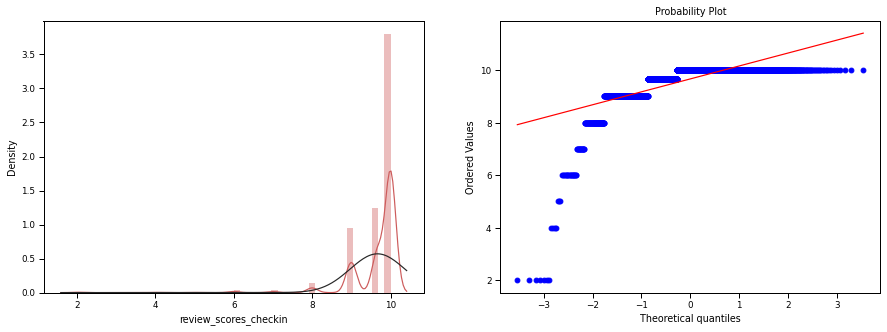

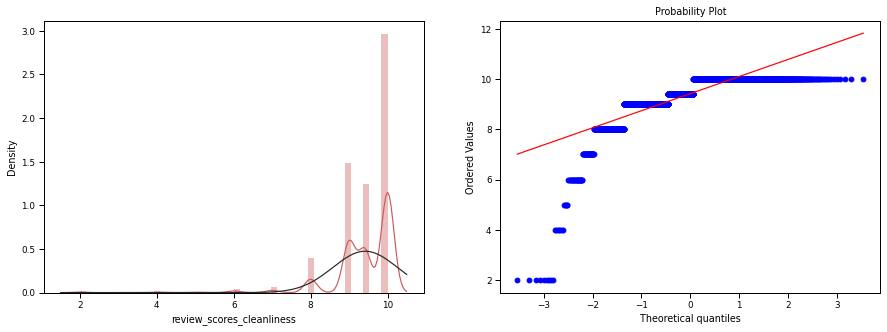

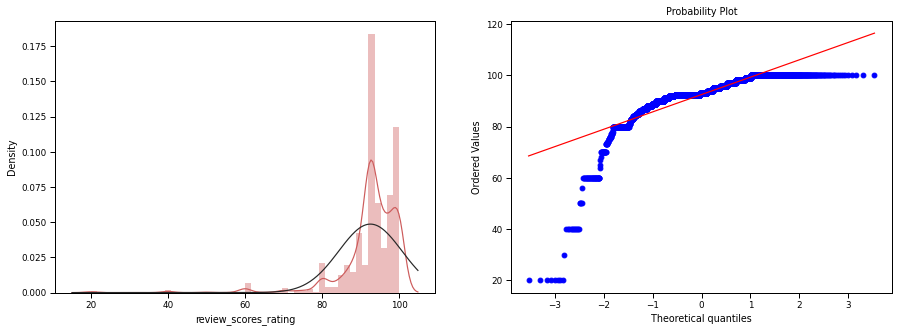

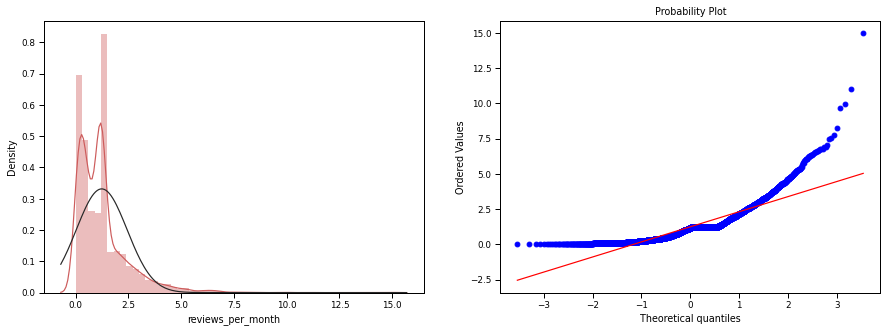

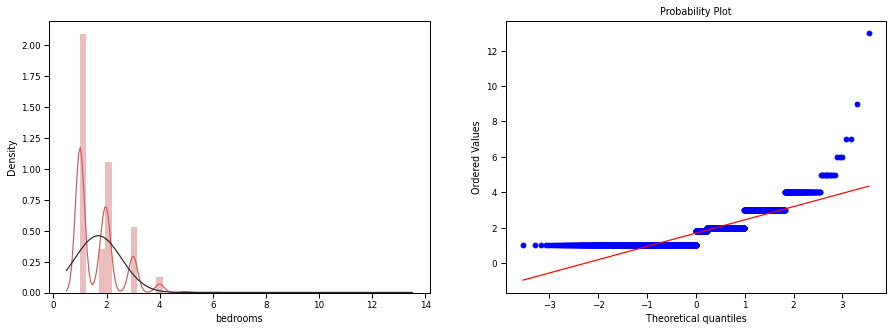

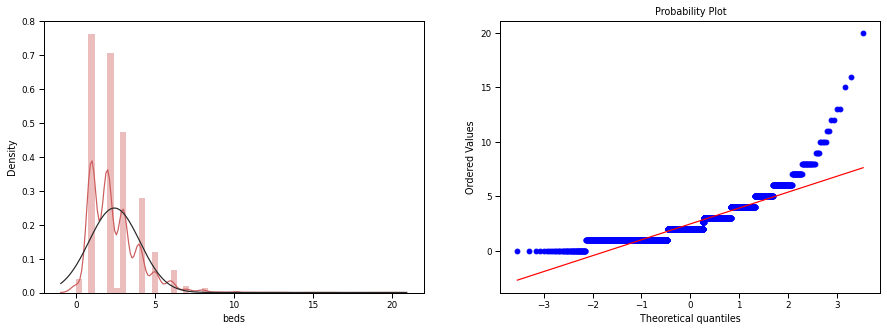

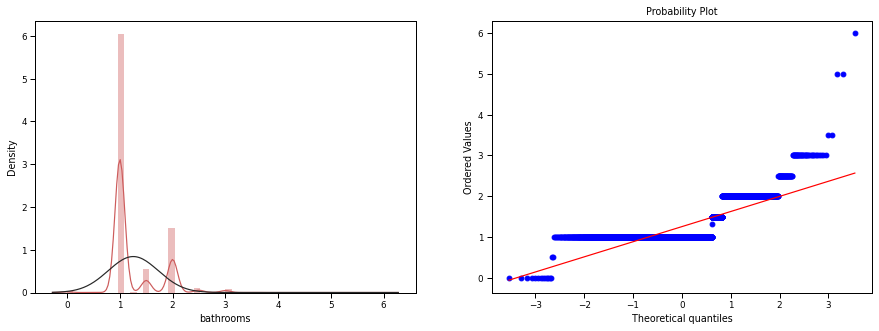

In [103]:
# extract numeric dtypes
numeric_variables = train_X.select_dtypes(['number']).columns.to_list()

# plot distribution
plot_dist(train_X, numeric_variables)

## Explore distribution of the target variable

First, let's explore the distribution of price in the whole dataset. We clearly see that price is not normally distributed with a slight right-positive skew.

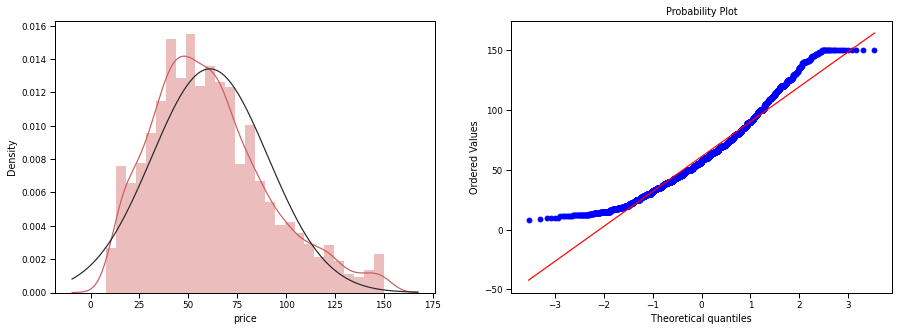

In [104]:
plot_dist(train_y)

Now let's see what happens when we apply a square root trasnformation to price. Okay, now it is normally distributed, although the data do not fit the line properly in the probability plot.

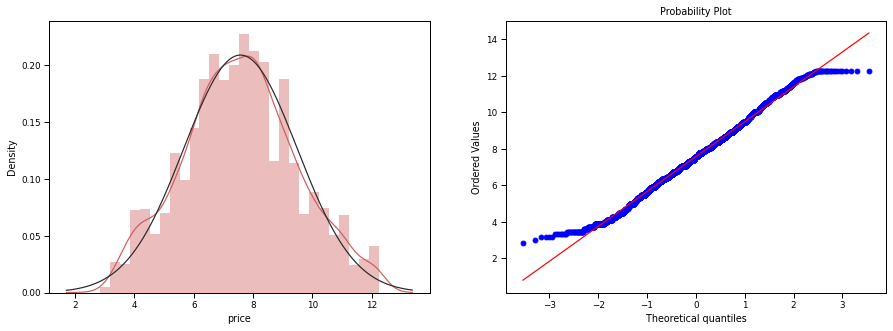

In [105]:
plot_dist(train_y, transformation=np.sqrt)

Let's apply the transformation.

In [106]:
train_y = np.sqrt(train_y)

Let's see how price is distributed between neighbourhoods. It is known that prices could have a non-normal distribution, so it could be possible that we will need to apply some transformation to data.

In [107]:
def plot_dist_per_group(df, list_of_groups, factor_column_name, dv_column_name, transformation=None):
    """
    Plot distribution of data by a certain group. If required, a transformation
    of the data could be applied.
    
    Input:
        df: DataFrame
        list_of_groups: list of the name of each group.
        factor_column_name: column name containing the groups.
        dv_column_name: variable to be plotted.
        trasnformation (numpy): transformation that wants
                                to be applied to the data.
    Output:
        Distribution plot and probability plot of each variable 
        for each group.
    """
    
    for group in list_of_groups:
        
        df_slice = df[df[factor_column_name] == group][dv_column_name]
        
        if transformation != None:
            df_slice = df_slice.apply(transformation)
        else:
            df_slice = df_slice
        
        print('Distribution for group: ' + str(group))
        fig, ax = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(df_slice, fit=norm, color='indianred', ax=ax[0])
        stats.probplot(df_slice.dropna(), plot=ax[1])
        plt.show()

After applying a logarithmic transformation we see that the price distribution of each neighbourhood approximates to a normal distribution. We can chose to perform a non-parametric test as Kuskal-Wallis, as the distribution of some neighbourhood still is non-normal distributed. However, is not far from beign normal, so we will still go on with ANOVA analysis. Just in case, we are going to check differences in variance also applying Kruskal-Wallis, a non-parametric approximation of ANOVA.

We should also consider that in some neighbourhoods the sample size is limited, compared to Centro and Este, which are easy to make normally distributed.

Distribution for group: Centro


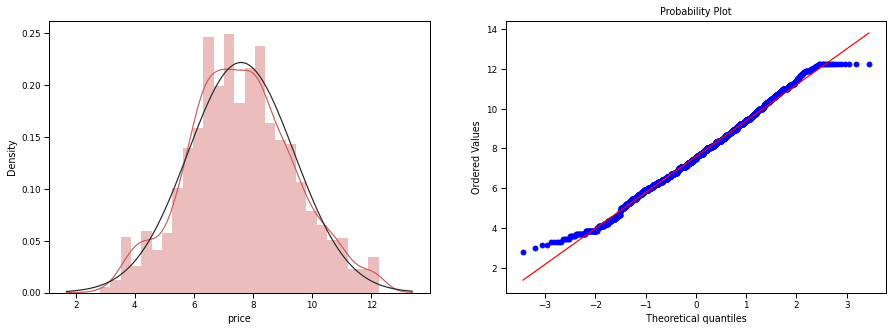

Distribution for group: Este


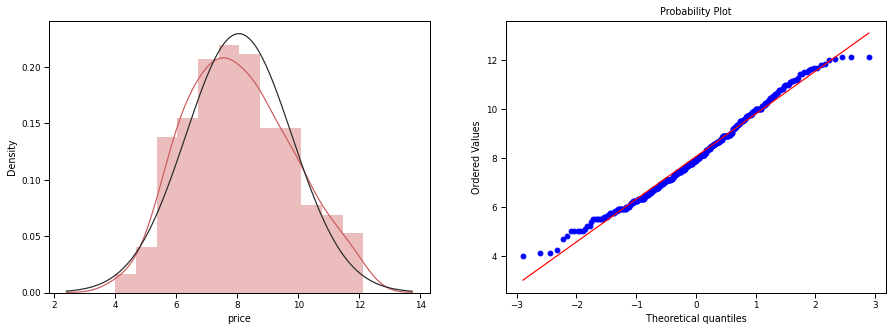

Distribution for group: Carretera de Cadiz


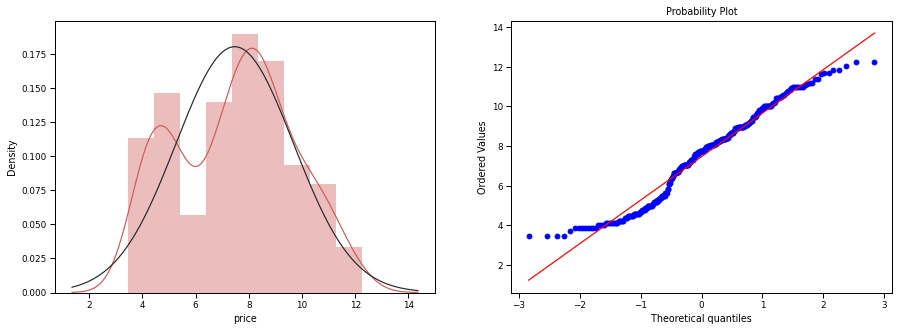

Distribution for group: Teatinos-Universidad


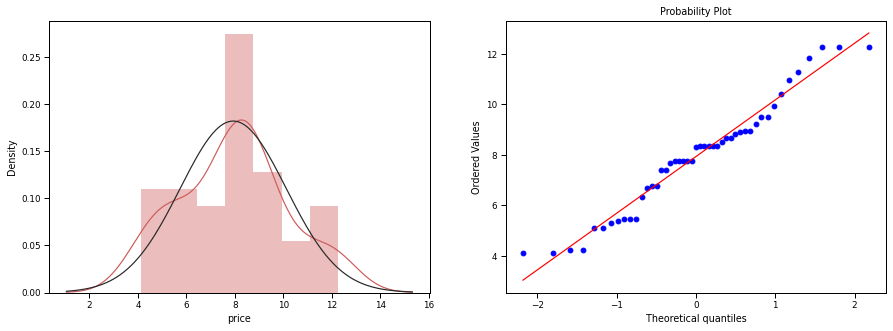

Distribution for group: Churriana


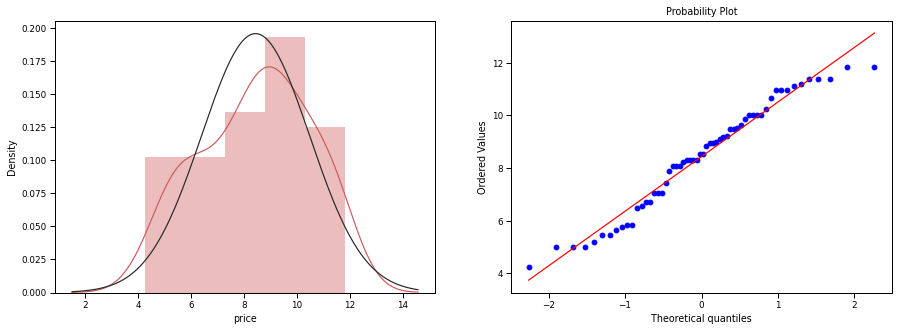

Distribution for group: Cruz De Humilladero


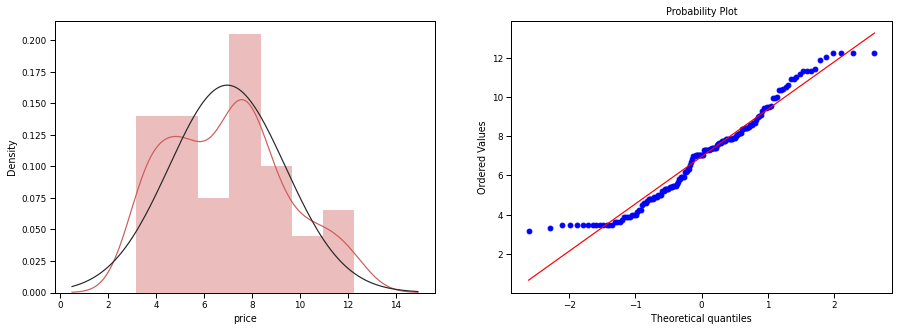

Distribution for group: Bailen-Miraflores


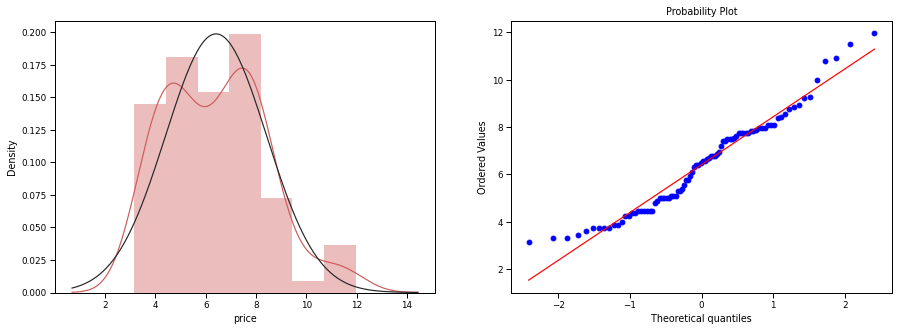

Distribution for group: Campanillas


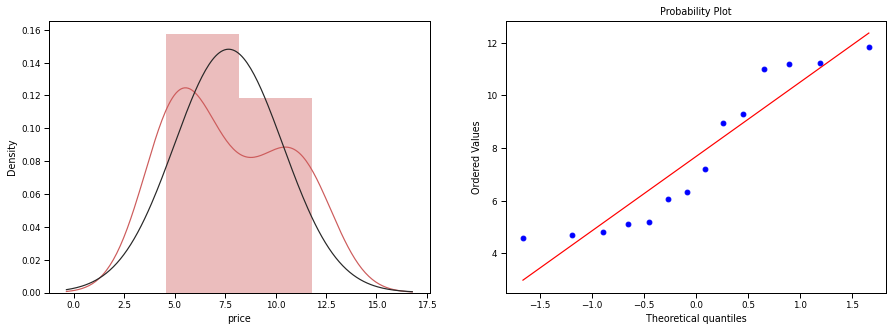

Distribution for group: Palma-Palmilla


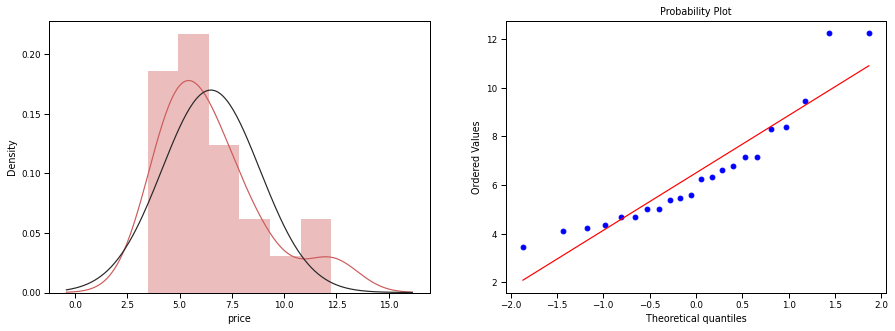

Distribution for group: Ciudad Jardin


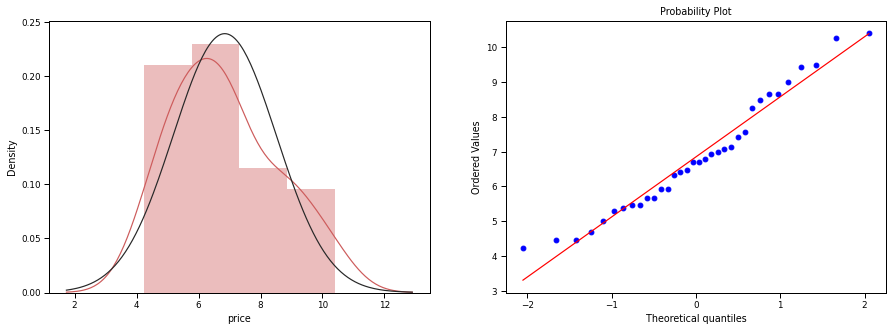

Distribution for group: Puerto de la Torre


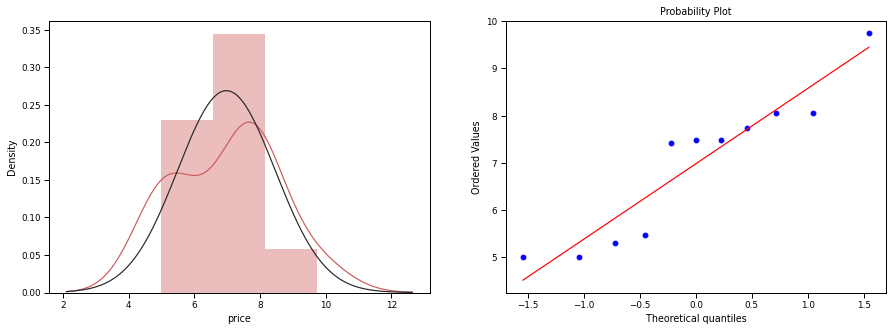

In [108]:
# let's concatenate X and y for this
X_y = pd.concat([train_X, train_y], axis=1)

# list of neighbourhoods
neighbourhoods_list = X_y['neighbourhood_cleansed'].unique().tolist()

# plot distribution per neighbourhood
plot_dist_per_group(X_y, neighbourhoods_list, 'neighbourhood_cleansed', 'price')

# Feature Selection of categorical variables

Let's check now if there is a significant effect of categorical variables. In this case I am only going to explore if there is a significant effect of each categorical variable on the price. We will use Analysis of Variance (ANOVA) for this. This statistical method gives us an F statistics. It is know that the higher the F statistic, the higher the correlation will be with our dependent variable.

We will use ANOVA as we want to select relevant features. If we use One Hot Encoding, we will createa new variable for different levels of the predictor, and then we will be selecting relevante feature levels and not the feature per se.

## Neighbourhood ANOVA

We have found a significant effect of neighbourhood over price. The test yield a F = 15.16 value using ANOVA over price. We will have to explore these differences between neighbourhoods performing t-tests. The same significant effect is yield applying a non-parametric test as Kruskal-Wallis.

In any case, we should consider Neighbourhood as a significant factor to contribute to our models, as we find an association between price and neighbourhood.

In [109]:
anova_neighbourhood = pg.anova(data=X_y, dv='price', between='neighbourhood_cleansed', detailed=True, effsize='np2')
kruskal_neighbourhood = pg.kruskal(data=X_y, dv='price', between='neighbourhood_cleansed', detailed=True)
display(anova_neighbourhood.round(3), kruskal_neighbourhood.round(3))

,Source,SS,DF,MS,F,p-unc,np2
0,neighbourhood_cleansed,358.007,10,35.801,10.017,0.0,0.028
1,Within,12354.943,3457,3.574,NaN,NaN,NaN


,Source,ddof1,H,p-unc
Kruskal,neighbourhood_cleansed,10,88.643,0.0


We will perform t-tests between different neighbourhood to see where the differences in prices arise. But first, let's explore how many neighbourhood we have.

Let's create first the possible combination between neighbourhoods and perform t-tests.

In [110]:
def multiple_comparisons(df, list_of_groups, factor_column_name, dv_column_name):
    """
    Performs multiple comparisons between groups of a given factor using
    T-Tests.
    
    Input:
        df: DataFrame
        list_of_groups: list of the name of each group.
        factor_column_name (str): column name containing the groups.
        dv_column_name (str): variable to be plotted.
    Output:
        final_results: DataFrame with the result of each comparison 
                       in each row.
    """

    list_results = []
    list_comparisons = []
    
    comparisons = combinations(list_of_groups, 2)
    for name1, name2 in comparisons:
        comparison_tuple = (name1, name2)
        list_comparisons.append(comparison_tuple)

    for tuple_combo in list_comparisons:
        print('Performing t-test for comparison: ' + str(tuple_combo[0]) + ' and ' + str(tuple_combo[1]))
        x = df[df[factor_column_name] == tuple_combo[0]][dv_column_name]
        y = df[df[factor_column_name] == tuple_combo[1]][dv_column_name]
        result = pg.ttest(x=x, y=y, paired=False, tail='two-sided', correction='auto')
        result[['X', 'Y']] = tuple_combo[0], tuple_combo[1]
        list_results.append(result)
        final_results = pd.concat(list_results)
    
    return final_results

Let's perform the t-test comparisons between neighbourhood to dig deeper in the significant differences in Málaga.


We see that the mean price in Bailén-Miraflores is lower compared to the rest of the neighbourhoods, we will explain this in the next paragaph.


Interesting, we see that Carretera de Cadiz has a mean price lower than some neighbourhoods as Campanillas. In Campanillas we found the Technological Park, maybe this could explain why we have some higher prices, as we can find there more hotels or less Airbnb accomodations but more valuable as though for certain business purposes rathen than tourism. The same happens with Churriana, as we find there Málaga-Costa del Sol airport. We can see that also Teoatinos-Universidad is closer to the city center than Carretera de Cadiz. However, we see that Bailén-Miraflores has a lower mean price, this could be possible as Carretera de Cadiz is closer to the beach.


Center area has higher prices compared to Cruz de Humilladero and Bailén-Miraflores. However, Churriana and Campanillas have higher mean price. This could be possible because of the Technological Park and the airport.


Finally, we see that Este area is the most expensive! We all know that Centro area have the harbour, whereas Este have one of the most touristic areas of the city, plus some beautiful beaches. Si, it is not surprising that Este is more expensive than Carretera de Cadiz, Cruz del Humilladero and Bailén-Miraflores.

Performing t-test for comparison: Centro and Este
Performing t-test for comparison: Centro and Carretera de Cadiz
Performing t-test for comparison: Centro and Teatinos-Universidad
Performing t-test for comparison: Centro and Churriana
Performing t-test for comparison: Centro and Cruz De Humilladero
Performing t-test for comparison: Centro and Bailen-Miraflores
Performing t-test for comparison: Centro and Campanillas
Performing t-test for comparison: Centro and Palma-Palmilla
Performing t-test for comparison: Centro and Ciudad Jardin
Performing t-test for comparison: Centro and Puerto de la Torre
Performing t-test for comparison: Este and Carretera de Cadiz
Performing t-test for comparison: Este and Teatinos-Universidad
Performing t-test for comparison: Este and Churriana
Performing t-test for comparison: Este and Cruz De Humilladero
Performing t-test for comparison: Este and Bailen-Miraflores
Performing t-test for comparison: Este and Campanillas
Performing t-test for comparison: Este 

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,X,Y
T-test,-3.239,83.875,two-sided,0.002,"[-1.56, -0.37]",0.441,20.216,0.867,Carretera de Cadiz,Churriana
T-test,2.172,281.649,two-sided,0.031,"[0.05, 0.97]",0.221,1.059,0.609,Carretera de Cadiz,Cruz De Humilladero
T-test,4.247,152.077,two-sided,0.000,"[0.57, 1.55]",0.488,620.257,0.981,Carretera de Cadiz,Bailen-Miraflores
T-test,-4.572,489.906,two-sided,0.000,"[-0.64, -0.26]",0.251,1870.474,0.994,Centro,Este
T-test,-3.090,59.160,two-sided,0.003,"[-1.39, -0.3]",0.466,13.154,0.939,Centro,Churriana
T-test,2.143,21.220,two-sided,0.044,"[0.03, 2.17]",0.609,1.687,0.811,Centro,Palma-Palmilla
T-test,2.559,34.085,two-sided,0.015,"[0.15, 1.34]",0.415,3.692,0.672,Centro,Ciudad Jardin
T-test,3.154,164.059,two-sided,0.002,"[0.24, 1.02]",0.341,11.759,0.984,Centro,Cruz De Humilladero
T-test,5.417,92.221,two-sided,0.000,"[0.75, 1.62]",0.654,1.584e+05,1.000,Centro,Bailen-Miraflores
T-test,2.692,17.387,two-sided,0.015,"[0.32, 2.6]",0.732,5.23,0.593,Churriana,Puerto de la Torre


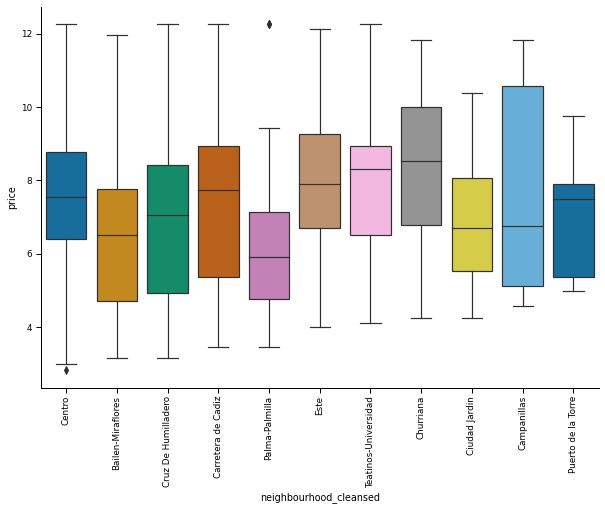

In [111]:
ttest = multiple_comparisons(X_y, neighbourhoods_list, 'neighbourhood_cleansed', 'price')

# show only significant t-tests
display(ttest[ttest['p-val'] <= .05].round(3).sort_values(by=['X', 'T'], ascending=True))

# plot boxplot
fig, ax = plt.subplots(figsize=(10, 7))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=X_y.sort_values(by=['price', 'neighbourhood_cleansed'],
                                                                              ascending=True), palette='colorblind')
plt.xticks(rotation=90)
sns.despine()

## Room type ANOVA

ANOVA and Kruskal-Wallis test show a significant result for room type, with a F value of 348.7 and a p-value < .001. Then, we will keep room type as a significant predictor for our model. Significant differences are found between entire accomodations with shared room and private room. As expected, the entire accomodation is more expensive that a shared or private room. Also, a Hotel room is more expensive than a private or shared room.

Performing t-test for comparison: Entire home/apt and Private room
Performing t-test for comparison: Entire home/apt and Hotel room
Performing t-test for comparison: Entire home/apt and Shared room
Performing t-test for comparison: Private room and Hotel room
Performing t-test for comparison: Private room and Shared room
Performing t-test for comparison: Hotel room and Shared room


,Source,SS,DF,MS,F,p-unc,np2
0,room_type,2964.638,3,988.213,351.155,0.0,0.233
1,Within,9748.311,3464,2.814,NaN,NaN,NaN


,Source,ddof1,H,p-unc
Kruskal,room_type,3,732.102,0.0


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,X,Y
T-test,10.938,10.213,two-sided,0.000,"[2.63, 3.98]",2.014,4.347e+23,1.000,Entire home/apt,Shared room
T-test,29.591,832.558,two-sided,0.000,"[2.23, 2.55]",1.422,2.809e+167,1.000,Entire home/apt,Private room
T-test,7.961,28.843,two-sided,0.000,"[2.57, 4.35]",2.477,2.029e+06,1.000,Hotel room,Shared room
T-test,-7.880,25.656,two-sided,0.000,"[-3.21, -1.88]",1.389,2.914e+11,1.000,Private room,Hotel room
T-test,2.959,11.268,two-sided,0.013,"[0.24, 1.6]",0.500,11.138,0.375,Private room,Shared room


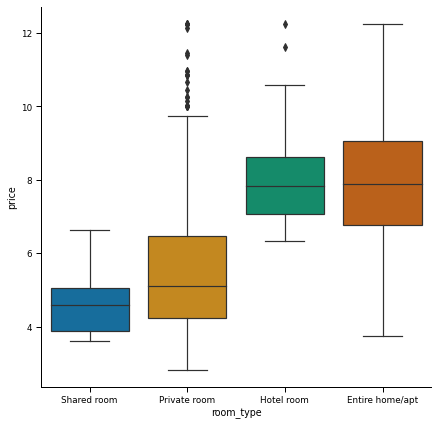

In [112]:
# room list
room_list = X_y['room_type'].unique().tolist()

# ANOVA and Kruskal-Wallis
anova_room = pg.anova(X_y, dv='price', between='room_type', detailed=True, effsize='np2')
kruskal_room = pg.kruskal(X_y, dv='price', between='room_type', detailed=True)

# pairwise-comparisons
ttests = multiple_comparisons(X_y, room_list, 'room_type', 'price')
sig_comparisons = ttests[ttests['p-val'] <= .05].round(3).sort_values(by=['X', 'T'], ascending=True)
display(anova_room.round(3), kruskal_room.round(3), sig_comparisons)

# plot boxplot
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(x='room_type', y='price', data=X_y.sort_values(by=['room_type', 'price'], ascending=False), 
            palette='colorblind')
sns.despine()

## Accomodation size ANOVA

ANOVA and Kruskal-Wallis test yield a significant result for accomodation size, with a F value of 757.32 and a p-value < .001. Based on these results, we will keep accomodation size as a significant predictor for our model.

As expected, there are significant differences in mean price depending on accomodation size. We can see in T-test comparisons that large accomodations are more expensive than medium and small, and also medium sizes are more expensive than small accomodations.

Performing t-test for comparison: large and medium
Performing t-test for comparison: large and small
Performing t-test for comparison: medium and small


,Source,SS,DF,MS,F,p-unc,np2
0,size,2955.666,2,1477.833,524.807,0.0,0.232
1,Within,9757.284,3465,2.816,NaN,NaN,NaN


,Source,ddof1,H,p-unc
Kruskal,size,2,787.409,0.0


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,X,Y
T-test,10.131,178.625,two-sided,0.0,"[1.13, 1.68]",0.872,2.417e+20,1.0,large,medium
T-test,21.815,201.622,two-sided,0.0,"[2.85, 3.41]",1.769,1.953e+87,1.0,large,small
T-test,28.020,2482.898,two-sided,0.0,"[1.6, 1.84]",1.025,1.42e+151,1.0,medium,small


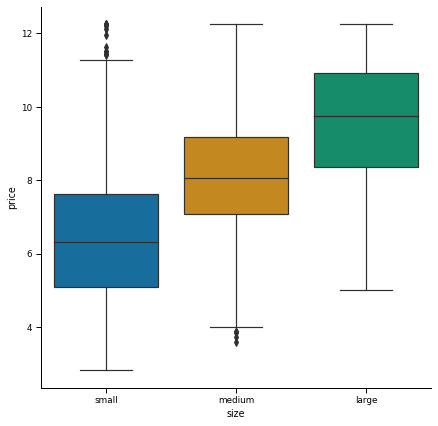

In [113]:
# size list
size_list = X_y['size'].unique().tolist()

# ANOVA and Kruskal-Wallis
anova_size = pg.anova(X_y, dv='price', between='size', detailed=True, effsize='np2')
kruskal_size = pg.kruskal(X_y, dv='price', between='size', detailed=True)

# pairwise-comparisons
ttests = multiple_comparisons(X_y, size_list, 'size', 'price')
sig_comparisons = ttests[ttests['p-val'] <= .05].round(3).sort_values(by=['X', 'T'], ascending=True)
display(anova_size.round(3), kruskal_size.round(3), sig_comparisons)

# plot boxplot
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(x='size', y='price', data=X_y, palette='colorblind', order=['small', 'medium', 'large'])
sns.despine()

## Superhost ANOVA

For the superhost feature, we see that no difference is appreciated in price, neither using parametric or non-parametric statistics (p-value > .05). We could decide to keep this feature in light of the marginal p-value found with Kruskal Wallis test, however I will be conservative and will remove this feature.

Performing t-test for comparison: f and t


,Source,SS,DF,MS,F,p-unc,np2
0,host_is_superhost,8.345,1,8.345,2.277,0.131,0.001
1,Within,12704.605,3466,3.665,NaN,NaN,NaN


,Source,ddof1,H,p-unc
Kruskal,host_is_superhost,1,3.559,0.059


,T,dof,tail,p-val,CI95%,cohen-d,BF10,power,X,Y


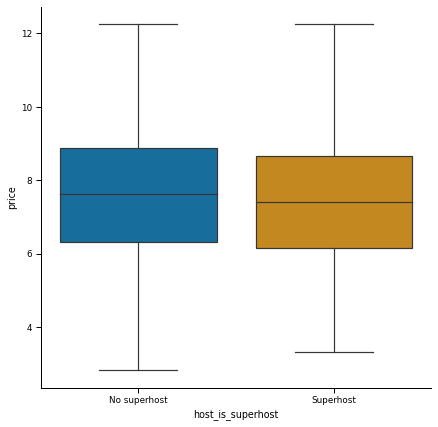

In [114]:
# size list
host_list = X_y['host_is_superhost'].unique().tolist()

# ANOVA and Kruskal-Wallis
anova_size = pg.anova(X_y, dv='price', between='host_is_superhost', detailed=True, effsize='np2')
kruskal_size = pg.kruskal(X_y, dv='price', between='host_is_superhost', detailed=True)

# pairwise-comparisons
ttests = multiple_comparisons(X_y, host_list, 'host_is_superhost', 'price')
sig_comparisons = ttests[ttests['p-val'] <= .05].round(3).sort_values(by=['X', 'T'], ascending=True)
display(anova_size.round(3), kruskal_size.round(3), sig_comparisons)

# plot boxplot
fig, ax = plt.subplots(figsize=(7, 7))
sns.boxplot(x='host_is_superhost', y='price', data=X_y, palette='colorblind')
plt.xticks(ticks=(0, 1), labels=['No superhost', 'Superhost'])
sns.despine()

In [115]:
train_X.drop(columns='host_is_superhost', inplace=True)

## Ordinal and dummy coding

We have selected categorical features performing Analysis of Variance for each variable. Now, I am curious about Sklearn methods. As we know, Sklearn only allows numerical, so first we will need to code our categorical variables into numbers. We will use OrdinalEncoder for those variables that can be coded in a certain direction. Then, we will get dummy variables for the non-ordinal ones.

### Encode ordinal variables

Size categories are labelled as:

* **0:** small
* **1:** medium
* **2:** large

In [116]:
def get_ordinal_vars(df, categories, col):
    """
    Encode orginal values given certain categories.
    
    Input:
        df: DataFrame.
        categories(list): list of categories to be encoded.
        col (str): name of the column to be coded.
    Output:
        df: DataFrame with values encoded.        
    """
    
    # specify order
    ord_enc = OrdinalEncoder(categories=[categories])
    # fit and transform
    df[col] = ord_enc.fit_transform(df[col].values.reshape(-1, 1))
    
    return df

train_X = get_ordinal_vars(train_X, ['small', 'medium', 'large'], 'size')

### Dummy coding for the rest of non-ordinal categorical variables

Let's recode the categorical variables and transform them into dummy variables to introduce them in regression. We will also remove the first column as it is not neccesary.

In [117]:
train_X = pd.get_dummies(train_X, drop_first=True)

# Multicollinearity

Now that we have created our dummy variables, let's assess multicolinerity. For this, we will use Variance Inflation Factor (VIF) value. If the VIF values lies between 0 and 10, we should not consider multicollinearity in our data.

In [118]:
def compute_vif(X):
    """
    Compute Variance Inflation Factor on a given dataset.
    Remove the highest VIF value and compute VIF again basedf
    on the remaining features in the DataFrame. Remove features
    while the highest VIF value is greater or equal to 10.
    
    Input:
        X: DataFrame.
    Output:
        X_vif: DataFrame without removed features.
        vif_original: DataFrame with VIF values for the
                      without removing any feature.
        vif: DataFrame with the Variance Inflation Factor
             computed for the remaining features after deletion.
        removed_features: list of removed features.
    """
    
    # compute VIF
    vif = pd.DataFrame()
    vif['variables'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif.sort_values(by='VIF', ascending=False, inplace=True)
    
    # deep copy of the original VIF values
    vif_original = vif.copy(deep=True)
    
    # initiate list
    removed_features = []
    
    # iterate and removed VIF values greater or equal to 10
    while vif['VIF'].iloc[0] >= 10:
        X.drop(columns=vif['variables'].iloc[0], inplace=True)
        removed_features.append(vif['variables'].iloc[0])
        vif = pd.DataFrame()
        vif['variables'] = X.columns
        vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif.sort_values(by='VIF', ascending=False, inplace=True)
    
    # remove features from the original DataFrame
    X_vif = X[X.columns[~X.columns.isin(removed_features)]]
    
    return X_vif, vif_original, vif, removed_features

Run function.

In [119]:
train_X, vif_original, vif_removed, removed_features = compute_vif(train_X)

We can see that the features removed based on a VIF greater or equal to 10 are in the following list.

In [120]:
removed_features

['latitude',
 'review_scores_rating',
 'review_scores_checkin',
 'longitude',
 'review_scores_accuracy',
 'review_scores_value',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_cleanliness',
 'accommodates',
 'bathrooms']

After removing some variables, we have reached a VIF below 10. We removed latitude and longitude, as most of the basic information is collected by neighbourhoods variables. Also, we removed accomodates and bathrooms, as this information could be reflected by beds, size or bedrooms. Most of the review variables have been removed, but reviews_per_months and number_of_reviews.

In [121]:
vif_removed

,variables,VIF
6,bedrooms,9.582153
10,neighbourhood_cleansed_Centro,9.245175
7,beds,8.156974
5,reviews_per_month,5.239755
4,size,5.213018
21,instant_bookable_t,4.220739
2,availability_365,3.806047
1,maximum_nights,3.795006
19,room_type_Private room,3.451096
3,number_of_reviews,3.384369


# Feature Selection among continuous variables and dummy coded categorical variables

## Standardize the data

Although we have used ANOVA to detect important categories to be kept as predictors, it could be possible that there are certain values among those categories that do not contribute to predict the target variable. As we have coded these as dummy, we are going to perform some Feature Selection to detect the most important values of those categories. We will also include the continuous variables.

Before performing Feature Selection, we will standardize the data using z-scores, so each variable will have mean = 0 and SD = 1. We will first normalize the training data and we will save the scaler objects for the training sets. We will use this scalers later to normalize the test sets for model validation.

In [122]:
def standardize_train(train_X, train_y, y_name):
    """
    Standardize predictors and target variables.
    
    Input:
        train_X: DataFrame with train predictors.
        train_y: Pandas series with train target variable.
        y_name(str): name of the target variables.
    Output:
        norm_train_X: normalized train predictors.
        norm_train_y: normalized train target.
        scaler_train_X: scaler fitted in predictors training data.
        scaler_train_y: scaler fitted in target training data.
    """
    
    # scale only not dummy columns
    not_dummy_cols = train_X.select_dtypes(exclude='uint8').columns.to_list()

    # extract rest of the untouched dummy variables. Drop index as when we build a new df
    # it will use a new index and not the same as the old cases
    X_dummy = train_X.drop(columns=not_dummy_cols).reset_index(drop=True)
    
    # scale train data
    scaler_train_X = StandardScaler()
    train_X_scaled = scaler_train_X.fit_transform(train_X[not_dummy_cols])
    train_X_scaled = pd.DataFrame(data=train_X_scaled, columns=train_X[not_dummy_cols].columns)
    
    # reshape pandas Series
    scaler_train_y = StandardScaler()
    train_y_scaled = scaler_train_y.fit_transform(train_y.values.reshape(-1, 1))

    # final df for train data
    z_train_X = pd.concat([train_X_scaled, X_dummy], axis=1)
    z_train_y = pd.Series(train_y_scaled.flatten(), name=y_name)

    return z_train_X, z_train_y, scaler_train_X, scaler_train_y

def standardize_test(test_X, test_y, scaler_train_X, scaler_train_y, y_name):
    """
    Standardize predictors and target variables of test data.
    
    Input:
        test_X: DataFrame with predictors.
        test_y: Pandas series with target variable.
        scaler_train_X: scaler fitted in predictors training data.
        scaler_train_y: scaler fitted in target training data.
        y_name(str): name of the target variables.
    Output:
        norm_test_X: normalized test predictors.
        norm_test_y: normalized test target.
    """
    
    # scale only not dummy columns
    not_dummy_cols = test_X.select_dtypes(exclude='uint8').columns.to_list()

    # extract rest of the untouched dummy variables. Drop index as when we build a new df
    # it will use a new index and not the same as the old cases
    X_dummy = test_X.drop(columns=not_dummy_cols).reset_index(drop=True)

    # scale train data
    test_X_scaled = scaler_train_X.transform(test_X[not_dummy_cols])
    test_X_cols = test_X[not_dummy_cols].columns.tolist()
    test_X_scaled = pd.DataFrame(data=test_X_scaled, columns=test_X[not_dummy_cols].columns)
    
    # reshape pandas Series
    test_y_scaled = scaler_train_y.transform(test_y.values.reshape(-1, 1))

    # final df for train data
    z_test_X = pd.concat([test_X_scaled, X_dummy], axis=1)
    z_test_y = pd.Series(test_y_scaled.flatten(), name=y_name)
    
    return z_test_X, z_test_y

In [123]:
train_X, train_y_z, scaler_X_train, scaler_y_train = standardize_train(train_X, train_y, 'price')

### Association between continuous variables

I always have love to see the correlation tables in a triangle shape, I have found this code in Bibor Szabo post in Medium. Thank you so much for merging this type of tables with heatmaps!

We can see that the higher the number of persons a host can accomodates, number of bedrooms and beds, the higher the price. However, we don't find any correlation of price with longitude and latitude, interesting... maybe associations with price will be better reflected with the neighbourhood. We should also consider that maybe we are going to see a high multicollinearity between 'accomodates' and 'beds' or 'bedrooms', so it could be good to keep only one of these features (i.e. 'accomodates'). Dropping these variables we are not going to lose much information, as it is already provided by 'accomodates'. Anyway, we will explore multicollinearity in further steps.

In general, based on correlation analysis it seems that the most important features are:

* Size
* Beds
* Bedrooms
* Room type - Private Room
* Bathroom type - Shared
* Reviews per month
* Number of reviews

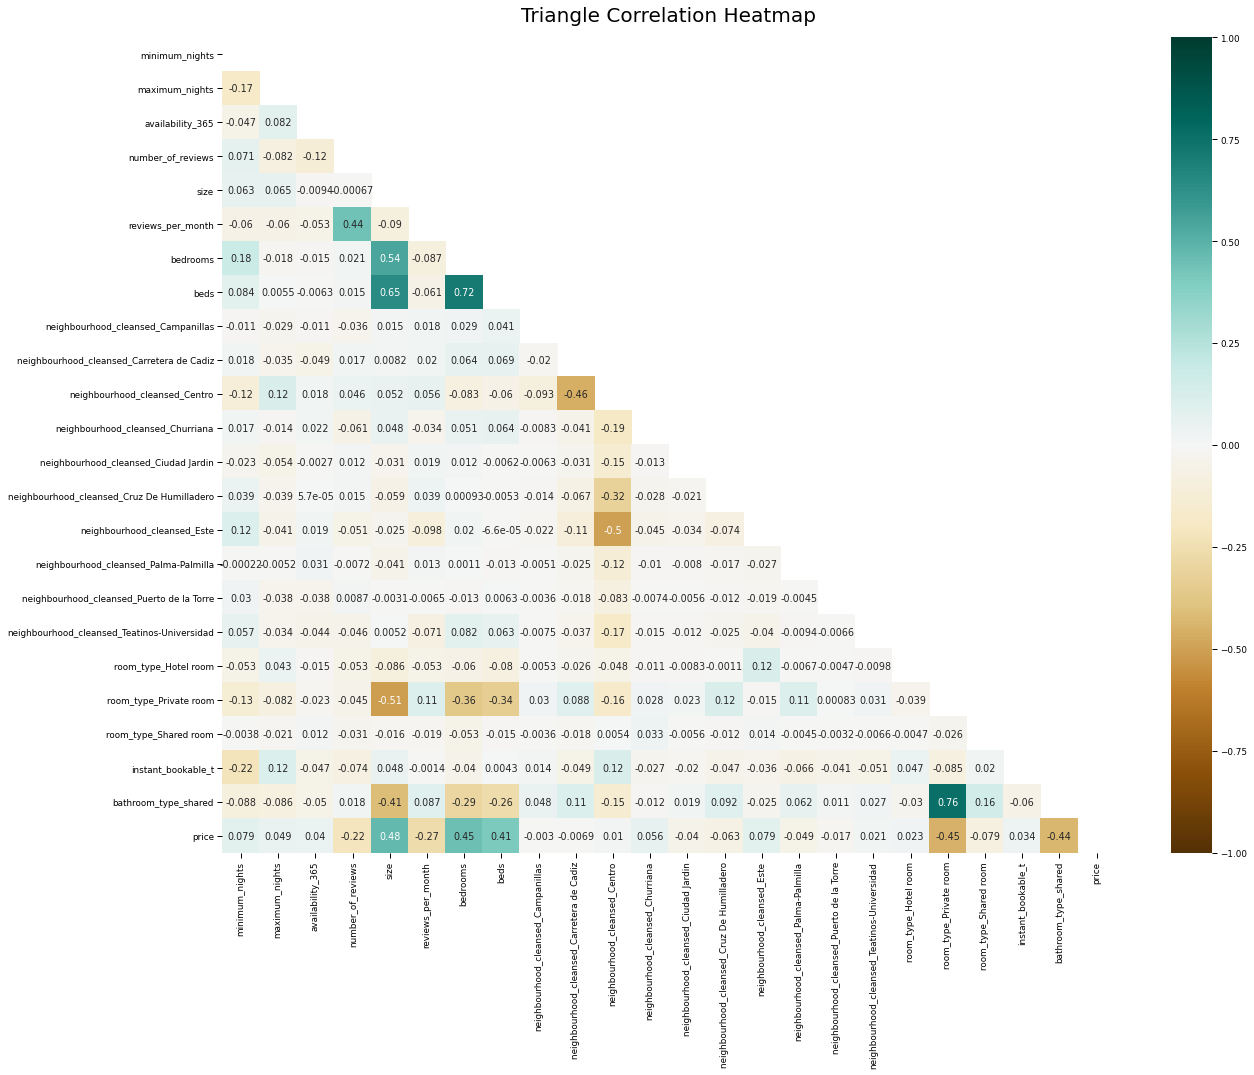

In [124]:
# concatenate the coded categorical variables with the predicted variable
train_coded = pd.concat([train_X, train_y_z], axis=1)

# compute correlations
np.triu(np.ones_like(train_coded.corr(method='spearman')))
plt.figure(figsize=(20, 15))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(train_coded.corr(method='spearman'), dtype=np.bool))
heatmap = sns.heatmap(train_coded.corr(method='spearman'), mask=mask, vmin=-1, vmax=1, annot=True, 
                      cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':20}, pad=16);

Let's explore also if these correlations are statistically significant based on p-values.

In [125]:
def correlations(df, var_list, tail, correction, method, cov_list, *args):
    
    """
    Compute correlations por each group of variables dropping variables of the same group (i.e. if 
    we have Depression_mother, Depression_father, Depression_daughter, correlations between these
    variables that are part of the same set of variables are excluded, only if we specified a common
    name of these variables ('Depression') in *args. Otherwise they are included.
    Apply a correction for multiple comparisons for all uncorrected p-values of each group of variables,
    not to all the correlatios in the DataFrame.
    Joins everything in an unique DataFrame.
    
    Input:
        df: DataFame with data.
        var_list: list of lists with variables for correlations.
        tail (str): 'one-sided' or 'two-sided'.
        correction (str): check statsmodels.multitest.multipletest for correction options.
        method (str): 'pearson', 'spearman', etc. (check methods for pg.pairwise_corr).
        cov_list: list of covariables.
        *args (str): strings to exclude intra group correlations from DataFrame and apply
                     correction without these correlations. The string should be a name that
                     is common to all the names of the varibles that are part of the group.
                     
                     Specify one string for the X column of the DataFrame: 
                     - 'Depression' if is the common string - Depression_mother, Depression_father, etc.
                        and we just have that group for the X column
                     - 'Depression|Anger' if we have two groups - Depression_mother, Depression_father, etc. +
                        Anger_mother, Anger_father, etc.
                     
                     Specify another string with the same logic for the Y column of the DataFrame.
    Output:
        df: DataFrame with correlation values dropping correlations between variables of the same group.
    """
    
    list_of_dfs = []
    
    #list_to_exclude_both_rows = [excludeintra_X, excludeintra_Y, excludeintra_Z]
    df_corr = pd.DataFrame(pg.pairwise_corr(df, columns=var_list, covar=cov_list, tail=tail, 
                                            method=method, nan_policy='pairwise')).round(5)
    
    # drop intra task correlations. Reset index because of dropped rows
    # to ease concat
    for row_excl in args:
    # drop rows that contains the same string in both columns X and Y
        df_corr = df_corr[~((df_corr['X'].str.contains(row_excl)) & 
                            (df_corr['Y'].str.contains(row_excl)))].reset_index(drop=True)
    
    # apply correction to p-values of no intratask correlations
    # transpose df as it returns two rows and multiple columns
    # and rename columns
    FDR_corr = list(smstats.multitest.multipletests(df_corr['p-unc'], alpha=0.05, method=correction, is_sorted=False, 
                                               returnsorted=False))
    # extract in a dict alpha corrected by Sidak and Bonferroni to ease concat
    alpha_SidakBonf = dict(alphacSidak=FDR_corr[2], alphacBonf=FDR_corr[3])
    # select two first elements, transpose and rename columns
    FDR_corr = pd.DataFrame(FDR_corr[0:2]).transpose().rename(columns={0: 'FDR', 1: 'pvals_corrected'})
    # add columns of p-values with FDR correction to df
    df_corr_FDR = pd.concat([df_corr, FDR_corr], axis=1, join='outer', ignore_index=False)
    # add cloumns with corrected p-values
    df_corr_FDR['alphacSidak'], df_corr_FDR['alphacBonf']=alpha_SidakBonf['alphacSidak'], alpha_SidakBonf['alphacBonf']
    # list of dfs, each df contains correlations for each frequency band
    list_of_dfs.append(df_corr_FDR)
        
    # concat list of dfs into 1 df
    # reset index. After concat remains the index of each df on its own rows
    df = pd.concat(list_of_dfs).reset_index(drop=True)
    
    return df

We will need a string with the variable names that we want to remove from the Y column in the corr DataFrame. We will create this from the original columns of 'train_coded' DataFrame removing 'price' (the target variable).

In [126]:
cols = train_coded.columns.tolist()[:-1]
cols_str = ''.join('|'.join(cols))
cols_str

'minimum_nights|maximum_nights|availability_365|number_of_reviews|size|reviews_per_month|bedrooms|beds|neighbourhood_cleansed_Campanillas|neighbourhood_cleansed_Carretera de Cadiz|neighbourhood_cleansed_Centro|neighbourhood_cleansed_Churriana|neighbourhood_cleansed_Ciudad Jardin|neighbourhood_cleansed_Cruz De Humilladero|neighbourhood_cleansed_Este|neighbourhood_cleansed_Palma-Palmilla|neighbourhood_cleansed_Puerto de la Torre|neighbourhood_cleansed_Teatinos-Universidad|room_type_Hotel room|room_type_Private room|room_type_Shared room|instant_bookable_t|bathroom_type_shared'

Let's compute the correlations applying the Benjamini-Hochberg False Discovery Rate correction. We will sort the correlations by the r statistic in descending order.

In [127]:
corr = correlations(train_coded, train_coded.columns.tolist(), 'two-sided', 'fdr_bh', 'spearman', 
                    [], 'None', cols_str).sort_values(by='r', ascending=False)

corr[corr['r'] > .20]

,X,Y,method,covar,tail,n,r,CI95%,r2,adj_r2,z,p-unc,power,FDR,pvals_corrected,alphacSidak,alphacBonf
4,size,price,spearman,[],two-sided,3468,0.47645,"[0.45, 0.5]",0.22700,0.22656,0.51838,0.0,1.0,True,0,0.002228,0.002174
6,bedrooms,price,spearman,[],two-sided,3468,0.45229,"[0.43, 0.48]",0.20456,0.20410,0.48757,0.0,1.0,True,0,0.002228,0.002174
7,beds,price,spearman,[],two-sided,3468,0.41375,"[0.39, 0.44]",0.17119,0.17071,0.44012,0.0,1.0,True,0,0.002228,0.002174


Features with a high frequence of constant values will be also dropped, as they will be adding unneccesary noise to the model. We will apply this function found in a Medium post (https://towardsdatascience.com/designing-a-feature-selection-pipeline-in-python-859fec4d1b12). This would only be applied to non-dummy features.

None features are dropped in this case.

In [128]:
def constant_features(X, frac_constant_values = 0.90):
    """
    Identifies features that have a large fraction of constant values.
    
    
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    frac_constant_values: float, optional (default = 0.90)
        The threshold used to identify features with a large fraction of 
        constant values.
        
    Returns
    -------
    labels: list
        A list with the labels identifying the features that contain a 
        large fraction of constant values.
    """
    
    # Get number of rows in X
    num_rows = X.shape[0]
    
    # Get column labels
    allLabels = X.columns.tolist()
    
    # Make a dict to store the fraction describing the value that occurs the most
    constant_per_feature = {label: X[label].value_counts().iloc[0]/num_rows for label in allLabels}
    
    # Determine the features that contain a fraction of missing values greater than
    # the specified threshold
    labels = [label for label in allLabels if constant_per_feature [label] > frac_constant_values]
    
    return labels

# Get selected features
X_selected = constant_features(train_X.select_dtypes(exclude='uint8'))
X_selected

[]

We have seen in the heatmap that come feature still share a high correlation values. I found this function in a Medium post (https://towardsdatascience.com/designing-a-feature-selection-pipeline-in-python-859fec4d1b12). I would save it here just in case, as it seems quite interesting to automatically remove those features that share a high correlation coefficient.

In [129]:
def correlated_features(X, correlation_threshold = 0.90):
    """
    Identifies features that are highly correlated. Let's assume that if
    two features or more are highly correlated, we can randomly select
    one of them and discard the rest without losing much information.
    
    
    Parameters
    ----------
    X : pandas dataframe
        A data set where each row is an observation and each column a feature.
        
    correlation_threshold: float, optional (default = 0.90)
        The threshold used to identify highly correlated features.
        
    Returns
    -------
    labels: list
        A list with the labels identifying the features that contain a 
        large fraction of constant values.
    """
    
    # Make correlation matrix
    corr_matrix = X.corr(method = "spearman").abs()
    
    
    # Select upper triangle of matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than correlation_threshold
    labels = [column for column in upper.columns if any(upper[column] >  correlation_threshold)]
    
    return labels

corr_features = correlated_features(train_X)
corr_features

[]

Now is time for some Feature Selection.

### F Regression

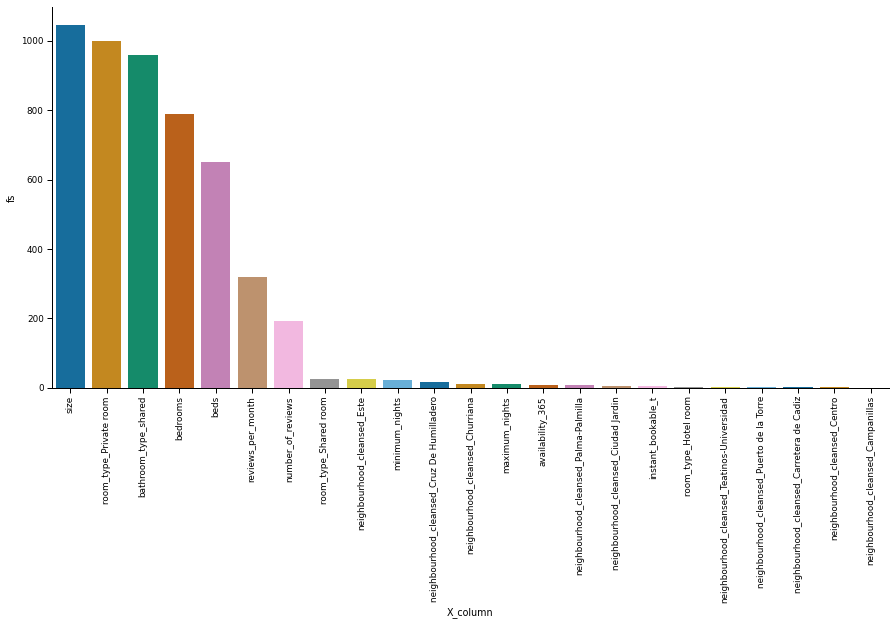

In [130]:
fs = SelectKBest(score_func=f_regression, k=10)
# learn relationship from training data
fs.fit(train_X, train_y)
# transform train input data
X_train_fs = fs.transform(train_X)

# ticks names and order
fs_scores = pd.DataFrame({'X_column': train_X.columns, 
                          'fs': fs.scores_}).sort_values(by='fs', ascending=False)

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(fs_scores['X_column'], fs_scores['fs'], palette='colorblind')
plt.xticks(rotation=90)
sns.despine()
plt.show()

### Random Forest

RMSE on train data:  1.074472512538282


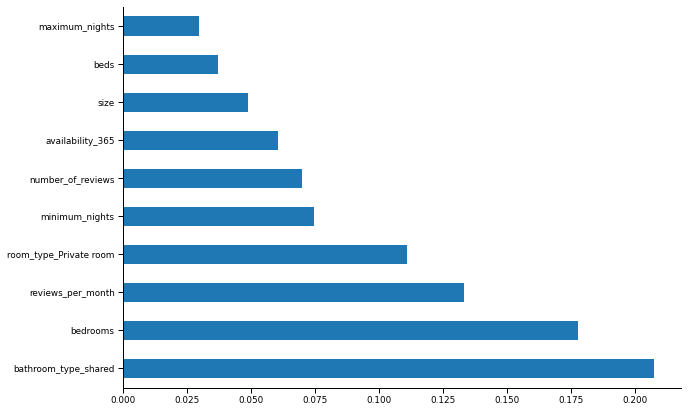

In [131]:
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_X, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_X)
#predict_test = model_RFR.predict(test_X)

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
#print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))

# plot the 7 most important features 
plt.figure(figsize=(10,7))
feat_importances = pd.Series(model_RFR.feature_importances_, index=train_X.columns)
feat_importances.nlargest(10).plot(kind='barh')
sns.despine()

### RFE with Lasso

In [132]:
# Feature extraction
model = LassoCV()
rfe = RFE(model, 10)
fit = rfe.fit(train_X, train_y)
print('Num Features: %s' % (fit.n_features_))
print('\n', 'Selected Features: %s' % (fit.support_))
print("\n', 'Feature Ranking: %s" % (fit.ranking_))
print('\n', train_X.columns[fit.support_])

Num Features: 10

 Selected Features: [False False False False  True  True  True False False  True False  True
 False False  True False False False  True  True  True False  True]

', 'Feature Ranking: [ 8 12 11  9  1  1  1  7  3  1  2  1  6  4  1 13 14  5  1  1  1 10  1]

 Index(['size', 'reviews_per_month', 'bedrooms',
       'neighbourhood_cleansed_Carretera de Cadiz',
       'neighbourhood_cleansed_Churriana', 'neighbourhood_cleansed_Este',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'bathroom_type_shared'],
      dtype='object')


### Backward Elimination

In [133]:
def backward_elimination(data, target, significance_level = 0.05):
    features = data.columns.tolist()
    target = target.values.reshape(-1, 1)
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break 
    return features

backward_elimination(train_X, train_y, significance_level=.05)

['minimum_nights',
 'number_of_reviews',
 'size',
 'reviews_per_month',
 'bedrooms',
 'beds',
 'neighbourhood_cleansed_Carretera de Cadiz',
 'neighbourhood_cleansed_Centro',
 'neighbourhood_cleansed_Churriana',
 'neighbourhood_cleansed_Cruz De Humilladero',
 'neighbourhood_cleansed_Este',
 'room_type_Hotel room',
 'room_type_Private room',
 'room_type_Shared room',
 'bathroom_type_shared']

### Stepwise Elimination

In [134]:
def stepwise_selection(data, target, SL_in=0.05, SL_out = 0.05):
    initial_features = data.columns.tolist()
    target = target.values.reshape(-1, 1)
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break 
        else:
            break
    return best_features

stepwise_selection(train_X, train_y, SL_in=.05, SL_out=.05)

['size',
 'bathroom_type_shared',
 'reviews_per_month',
 'bedrooms',
 'room_type_Private room',
 'minimum_nights',
 'neighbourhood_cleansed_Este',
 'room_type_Shared room',
 'beds',
 'neighbourhood_cleansed_Churriana',
 'neighbourhood_cleansed_Ciudad Jardin',
 'number_of_reviews',
 'room_type_Hotel room']

# Regression


First, we are going to define different list of features:

* 1. Features selected by Random Forest.
* 2. The same features selected by Random Forest removing the two features with least support.
* 3. Features selected by F 
* 4. Features selected by RFE

In [135]:
# selected by Random Forest
selected_features = ['room_type_Private room', 'bedrooms', 'reviews_per_month', 'minimum_nights', 'size',
                     'bathroom_type_shared', 'number_of_reviews', 'availability_365', 'beds', 'maximum_nights']

# try removing the 3 with less importance of the initially selected features by Random Forest
selected_features_supp = ['room_type_Private room', 'bedrooms', 'reviews_per_month', 'minimum_nights', 'size',
                          'bathroom_type_shared', 'number_of_reviews', 'availability_365']

# selected by F regression
selected_features_F = ['room_type_Private room', 'reviews_per_month', 'size',
                       'bathroom_type_shared', 'number_of_reviews', 'beds', 'bedrooms']

# selected by RFE
selected_features_RFE = ['size', 'reviews_per_month', 'bedrooms',
                         'neighbourhood_cleansed_Carretera de Cadiz',
                         'neighbourhood_cleansed_Churriana', 'neighbourhood_cleansed_Este',
                         'room_type_Hotel room', 'room_type_Private room',
                         'room_type_Shared room', 'bathroom_type_shared']

Now that we have preprocessed the training sets and selected relevant features, it is time to preprocess the test data in the same way. 

**In my next project I will build custom transformers to include then in a Pipeline in order to ease data preprocessing and fit the model**

In [136]:
# impute data in test X and y
series = test_X.isnull().sum().sort_values(ascending=False)
list_miss = series[series > 0].index.to_list()
# SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# to DataFrame
imputed = pd.DataFrame(data=imp.fit_transform(test_X[list_miss].to_numpy()), columns=list_miss)
# concatenate the imputed columns to the rest of the DataFrame
test_X = pd.concat([test_X.drop(columns=list_miss), imputed], axis=1)
# SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# to DataFrame
test_y = pd.Series(data=imp.fit_transform(test_y.values.reshape(-1, 1)).flatten(), name='price')
# drop
test_X = test_X.drop(columns=['property_type', 'id', 'host_id'])
# outliers
test_X, test_y = iqr(test_X, test_y)
# sqrt transformation
test_y = np.sqrt(test_y)
# remove 'host_is_superhost' feature
test_X.drop(columns='host_is_superhost', inplace=True)
# ordinal values
test_X = get_ordinal_vars(test_X, ['small', 'medium', 'large'], 'size')
# dummy coding
test_X = pd.get_dummies(test_X, drop_first=True)
# VIF above the threshold
test_X.drop(columns=removed_features, inplace=True)
# normalization
test_X, test_y_z = standardize_test(test_X, test_y, scaler_X_train, scaler_y_train, 'price')

IQR is: 44.0 with a lower limit: -25.0 and a upper limit: 151.0
In general we have: 96 outliers in the dataset


Finally, we will have to transform the DataFrames into Numpy arrays to fit them into the regression model.

In [137]:
# training set
train_X_np = train_X.to_numpy()
train_y_np = train_y.to_numpy()
train_y_z_np = train_y_z.to_numpy()

# test set
test_X_np = test_X.to_numpy()
test_y_np = test_y.to_numpy()
test_y_z_np = test_y_z.to_numpy()

We are going to perform GridSearch for hyperparameter tuning, we will also use a 5-fold cross-validation.

* R square will be computed  to find the goodness of fit measure.

* MSE and Root Mean Square Error (RMSE) as a measure of accuracy of prediction.

* Mean Absolute Error (MAE) to account for the difference between predictions and actual values.

## Lasso

In [138]:
def lasso_reg(X_train_data, y_train_data, X_test_data, y_test_data):
    """
    Built Linear Regression model applying L1 regularization. Uses 5 KFold
    cross-validation and GridSearchCV for hyperparameter tuning.
    
    Input:
        X_train_data: X training data as Numpy array.
        y_train_data: y training data as Numpy array.
        X_test_data: X test data as Numpy array.
        y_test_data: y test data as Numpy array.
    Output:
        pred_lasso: method to predict unseen data.
    """
    
    # initiate model
    lasso = Lasso()
    
    # grid search params
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # we will keep normalize=False (default) as the data is already scaled
    param_grid = {'alpha': np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])}
    
    # GridSearchCV
    lasso_cv = GridSearchCV(estimator=lasso, 
                            param_grid=param_grid, 
                            cv=folds,
                            scoring='neg_mean_squared_error')
    
    # Lasso fits on the training set for hyperparamether tuning
    lasso_cv.fit(X_train_data, y_train_data)

    # best params
    lasso_best_params = lasso_cv.best_params_
    lasso_best_score = lasso_cv.best_score_

    # print
    print('Best parameters for Lasso Regression: ' + str(lasso_best_params) + '\n' + 
          'Best score for Lasso Regression: ' + str(lasso_best_score) + '\n')
    
    # apply best params
    lasso_model = Lasso(alpha=lasso_best_params['alpha'])
    
    # fit model
    lasso_model.fit(X_train_data, y_train_data)
    # predict in the test and train sets
    pred_test_lasso = lasso_model.predict(X_test_data)
    pred_train_lasso = lasso_model.predict(X_train_data)
    
    # compute scores
    
    # R squared
    lasso_score = lasso_model.score(X_test_data, y_test_data)
    lasso_score_train = lasso_model.score(X_train_data, y_train_data)
    # MSE
    mse = mean_squared_error(y_test_data, pred_test_lasso)
    mse_train = mean_squared_error(y_train_data, pred_train_lasso)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_data, pred_test_lasso))
    rmse_train = np.sqrt(mean_squared_error(y_train_data, pred_train_lasso))
    #MAE
    mae = mean_absolute_error(y_test_data, pred_test_lasso)
    mae_train = mean_absolute_error(y_train_data, pred_train_lasso)

    print('R Squared on test data: ' + str(lasso_score) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(mse) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rmse) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(mae) + '\n')

    print('R Squared on train data: ' + str(lasso_score_train) + '\n' + 
          'Mean Squared Error (MSE) on train data: ' + str(mse_train) + '\n' + 
          'Root Mean Squared Error (RMSE) on train data: ' + str(rmse_train) + '\n' +
          'Mean Absolute Error (MAE) on train data: ' + str(mae_train) + '\n')
    
    return pred_test_lasso, y_test_data

## Ridge

In [139]:
def ridge_reg(X_train_data, y_train_data, X_test_data, y_test_data):
    """
    Builds Linear Regression model applying L2 regularization. Uses 5 KFold
    cross-validation and GridSearchCV for hyperparameter tuning.
    
    Input:
        X_train_data: X training data as Numpy array.
        y_train_data: y training data as Numpy array.
        X_test_data: X test data as Numpy array.
        y_test_data: y test data as Numpy array.
    Output:
        pred_ridge: method to predict unseen data.
    """
        
    # initiate model
    ridge = Ridge()
    
    # grid search params
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # we will keep normalize=False (default) as the data is already scaled
    param_grid = {'alpha': np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])}
    
    # GridSearchCV
    ridge_cv = GridSearchCV(estimator=ridge, 
                            param_grid=param_grid, 
                            cv=folds,
                            scoring='neg_mean_squared_error')
    
    # Lasso fits on the training set for hyperparamether tuning
    ridge_cv.fit(X_train_data, y_train_data)

    # best params
    ridge_best_params = ridge_cv.best_params_
    ridge_best_score = ridge_cv.best_score_

    # print
    print('Best parameters for Ridge Regression: ' + str(ridge_best_params) + '\n' + 
          'Best score for Ridge Regression: ' + str(ridge_best_score) + '\n')
    
    # apply best params
    ridge_model = Ridge(alpha=ridge_best_params['alpha'])
    
    # fit model
    ridge_model.fit(X_train_data, y_train_data)
    # predict in the test and train sets
    pred_test_ridge = ridge_model.predict(X_test_data)
    pred_train_ridge = ridge_model.predict(X_train_data)
    
    # compute scores
    
    # R squared
    ridge_score = ridge_model.score(X_test_data, y_test_data)
    ridge_score_train = ridge_model.score(X_train_data, y_train_data)
    # MSE
    mse = mean_squared_error(y_test_data, pred_test_ridge)
    mse_train = mean_squared_error(y_train_data, pred_train_ridge)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_data, pred_test_ridge))
    rmse_train = np.sqrt(mean_squared_error(y_train_data, pred_train_ridge))
    #MAE
    mae = mean_absolute_error(y_test_data, pred_test_ridge)
    mae_train = mean_absolute_error(y_train_data, pred_train_ridge)

    print('R Squared on test data: ' + str(ridge_score) + '\n' + 
          'Mean Squared Error (MSE) on test data: ' + str(mse) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rmse) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(mae) + '\n')

    print('R Squared on train data: ' + str(ridge_score_train) + '\n' + 
          'Mean Squared Error (MSE) on train data: ' + str(mse_train) + '\n' + 
          'Root Mean Squared Error (RMSE) on train data: ' + str(rmse_train) + '\n' +
          'Mean Absolute Error (MAE) on train data: ' + str(mae_train) + '\n')
    
    return pred_test_ridge, y_test_data

## ElasticNet

In [140]:
def elasticnet_reg(X_train_data, y_train_data, X_test_data, y_test_data):
    """
    Built Linear Regression model applying L1 and L2 regularization. Uses 5 KFold
    cross-validation and GridSearchCV for hyperparameter tuning.
    
    Input:
        X_train_data: X training data as Numpy array.
        y_train_data: y training data as Numpy array.
        X_test_data: X test data as Numpy array.
        y_test_data: y test data as Numpy array.
    Output:
        pred_elastic: method to predict unseen data.
    """
    
    # initiate model
    elastic = ElasticNet()
    
    # grid search params
    folds = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # we will keep normalize=False (default) as the data is already scaled
    param_grid = {'alpha': np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])}
    
    # GridSearchCV
    elastic_cv = GridSearchCV(estimator=elastic, 
                              param_grid=param_grid, 
                              cv=folds,
                              scoring='neg_mean_squared_error')
    
    # Lasso fits on the training set for hyperparamether tuning
    elastic_cv.fit(X_train_data, y_train_data)

    # best params
    elastic_best_params = elastic_cv.best_params_
    # mean cross validated fo the best estimator
    elastic_best_score = elastic_cv.best_score_

    # print
    print('Best parameters for ElasticNet Regression: ' + str(elastic_best_params) + '\n' + 
          'Best score for ElasticNet Regression: ' + str(elastic_best_score) + '\n')
    
    # apply best params
    elastic_model = ElasticNet(alpha=elastic_best_params['alpha'])
    
    # fit model
    elastic_model.fit(X_train_data, y_train_data)
    # predict in the test and train sets
    pred_test_elastic = elastic_model.predict(X_test_data)
    pred_train_elastic = elastic_model.predict(X_train_data)
    
    # compute scores
    
    # R squared
    elastic_score = elastic_model.score(X_test_data, y_test_data)
    elastic_score_train = elastic_model.score(X_train_data, y_train_data)
    # MSE
    mse = mean_squared_error(y_test_data, pred_test_elastic)
    mse_train = mean_squared_error(y_train_data, pred_train_elastic)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test_data, pred_test_elastic))
    rmse_train = np.sqrt(mean_squared_error(y_train_data, pred_train_elastic))
    #MAE
    mae = mean_absolute_error(y_test_data, pred_test_elastic)
    mae_train = mean_absolute_error(y_train_data, pred_train_elastic)

    print('R Squared on test data: ' + str(elastic_score) + '\n' + 
          'Mean Squared Error (RMSE) on test data: ' + str(mse) + '\n' + 
          'Root Mean Squared Error (RMSE) on test data: ' + str(rmse) + '\n' +
          'Mean Absolute Error (MAE) on test data: ' + str(mae) + '\n')

    print('R Squared on train data: ' + str(elastic_score_train) + '\n' + 
          'Mean Squared Error (MSE) on train data: ' + str(mse_train) + '\n' + 
          'Root Mean Squared Error (RMSE) on train data: ' + str(rmse_train) + '\n' +
          'Mean Absolute Error (MSE) on train data: ' + str(mae_train) + '\n')
    
    return pred_test_elastic, y_test_data

## Random Forest

In [141]:
def randomforest_reg(X_train_data, y_train_data, X_test_data, y_test_data, rf_best_params=None):
    """
    Built Linear Regression model applying L2 regularization. Uses 5 KFold
    cross-validation and GridSearchCV for hyperparameter tuning.
    
    Input:
        X_train_data: X training data as Numpy array.
        y_train_data: y training data as Numpy array.
        X_test_data: X test data as Numpy array.
        y_test_data: y test data as Numpy array.
        rf_best_params: parameter for hyperparameter tuning. As RF
                        more expensiev computationally, we can 
                        perform hyperparameter tunning, save them and
                        applying them later. If no tunning wants to be
                        performed then None.
    Output:
        pred_rf: method to predict unseen data.
    """
    
    if rf_best_params == None:
        
        # initiate model
        rf = RandomForestRegressor()

        # grid search params
        folds = KFold(n_splits=5, shuffle=True, random_state=42)

        n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
        max_features = ['auto', 'sqrt']
        max_depth = [int(x) for x in np.linspace(10, 110, num = 6)]
        max_depth.append(None)

        # param_grid
        param_grid = {'n_estimators': n_estimators,
                      'max_features': ['auto', 'sqrt', 'log2'],
                      'max_depth': max_depth,
                      'min_samples_split': [2, 5, 10],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False]}

        rf_cv = RandomizedSearchCV(estimator=rf,
                                   param_distributions=param_grid,
                                   n_iter=200,
                                   cv=folds,
                                   scoring='neg_mean_squared_error')

        # Lasso fits on the training set for hyperparamether tuning
        rf_cv.fit(X_train_data, y_train_data)

        # best params
        rf_best_params = rf_cv.best_params_
        # mean cross validated fo the best estimator
        rf_best_score = rf_cv.best_score_
    
        # print
        print('Best parameters for Random Forest Regressor: ' + str(rf_best_params) + '\n' + 
              'Best score for Random Forest Regressor: ' + str(rf_best_score) + '\n')
    
    else:
    
        # apply best params
        rf_model = RandomForestRegressor(n_estimators=rf_best_params['n_estimators'],
                                         max_features=rf_best_params['max_features'],
                                         max_depth=rf_best_params['max_depth'],
                                         min_samples_split=rf_best_params['min_samples_split'],
                                         min_samples_leaf=rf_best_params['min_samples_leaf'],
                                         bootstrap=rf_best_params['bootstrap'])

        # fit model
        rf_model.fit(X_train_data, y_train_data)
        # predict in the test and train sets
        pred_test_rf = rf_model.predict(X_test_data)
        pred_train_rf = rf_model.predict(X_train_data)

        # compute scores

        # R squared
        rf_score = rf_model.score(X_test_data, y_test_data)
        rf_score_train = rf_model.score(X_train_data, y_train_data)
        # MSE
        mse = mean_squared_error(y_test_data, pred_test_rf)
        mse_train = mean_squared_error(y_train_data, pred_train_rf)
        # RMSE
        rmse = np.sqrt(mean_squared_error(y_test_data, pred_test_rf))
        rmse_train = np.sqrt(mean_squared_error(y_train_data, pred_train_rf))
        #MAE
        mae = mean_absolute_error(y_test_data, pred_test_rf)
        mae_train = mean_absolute_error(y_train_data, pred_train_rf)

        print('R Squared on test data: ' + str(rf_score) + '\n' + 
              'Mean Squared Error (MSE) on test data: ' + str(mse) + '\n' + 
              'Root Mean Squared Error (RMSE) on test data: ' + str(rmse) + '\n' +
              'Mean Absolute Error (MAE) on test data: ' + str(mae) + '\n')

        print('R Squared on train data: ' + str(rf_score_train) + '\n' + 
              'Mean Squared Error (MSE) on train data: ' + str(mse_train) + '\n' + 
              'Root Mean Squared Error (RMSE) on train data: ' + str(rmse_train) + '\n' +
              'Mean Absolute Error (MAE) on train data: ' + str(mae_train) + '\n')
    
        return pred_test_rf, y_test_data

## Fit model with all features

### Find best hyperparameters for Random Forest (without target normalization)

In [189]:
pred_rf = randomforest_reg(train_X_np, train_y_np, test_X_np, test_y_np, rf_best_params=None)

Best parameters for Random Forest Regressor: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 110, 'bootstrap': False}
Best score for Random Forest Regressor: -1.8156232299877855



Best parameters for Random Forest Regressor:

* n_estimators: 800, 
* min_samples_split: 2, 
* min_samples_leaf: 2, 
* max_features: 'log2', 
* max_depth: 110, 
* bootstrap: False

Best score for Random Forest Regressor: -1.8156232299877855

### Find best hyperparameters for Random Forest (with target normalization)

In [191]:
pred_rf = randomforest_reg(train_X_np, train_y_z_np, test_X_np, test_y_z_np, rf_best_params=None)

Best parameters for Random Forest Regressor: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}
Best score for Random Forest Regressor: -0.4953935994356984



Best parameters for Random Forest Regressor: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': False}

Best score for Random Forest Regressor: -0.4953935994356984

### Fit models

In [142]:
print('\n -------- LASSO REGRESSION (L1 REGULARIZATION) -------- \n')
pred_lasso, y_test_lasso = lasso_reg(train_X_np, train_y_np, test_X_np, test_y_np)
#y_test_lasso, pred_lasso_kfold = lasso_reg_kfold(X, y, train_X_np, train_y_np, test_X_np, test_y_np)
print('\n -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- \n')
pred_ridge, y_test_ridge = ridge_reg(train_X_np, train_y_np, test_X_np, test_y_np)
#y_test_ridge, pred_ridge_kfold = ridge_reg_kfold(X, y, train_X_np, train_y_np, test_X_np, test_y_np)
print('\n -------- ELASTICNET REGRESSION (L1 AND L2 REGULARIZATION) -------- \n')
pred_elasticnet, y_test_elasticnet = elasticnet_reg(train_X_np, train_y_np, test_X_np, test_y_np)
#y_test_elasticnet, pred_elasticnet_kfold = elasticnet_reg_kfold(X, y, train_X_np, train_y_np, test_X_np, test_y_np)
print('\n -------- RANDOM FOREST REGRESSION -------- \n')
rf_best_params = {'n_estimators': 800, 
                  'min_samples_split': 2, 
                  'min_samples_leaf': 2, 
                  'max_features': 'log2', 
                  'max_depth': 110, 
                  'bootstrap': False}
pred_rf, y_test_rf = randomforest_reg(train_X_np, train_y_np, test_X_np, test_y_np, rf_best_params)


 -------- LASSO REGRESSION (L1 REGULARIZATION) -------- 

Best parameters for Lasso Regression: {'alpha': 0.0}
Best score for Lasso Regression: -2.152622930968718

R Squared on test data: 0.41412473173046127
Mean Squared Error (MSE) on test data: 2.113002188230052
Root Mean Squared Error (RMSE) on test data: 1.4536169331120397
Mean Absolute Error (MAE) on test data: 1.1445883240758887

R Squared on train data: 0.4225024048664948
Mean Squared Error (MSE) on train data: 2.1169832337947248
Root Mean Squared Error (RMSE) on train data: 1.4549856472813485
Mean Absolute Error (MAE) on train data: 1.1491498625143302


 -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- 

Best parameters for Ridge Regression: {'alpha': 0.1}
Best score for Ridge Regression: -2.1526003664653763

R Squared on test data: 0.41405239218258605
Mean Squared Error (MSE) on test data: 2.113263086122887
Root Mean Squared Error (RMSE) on test data: 1.4537066712796247
Mean Absolute Error (MAE) on test data: 1.14469710

## Fit model on features selected by Random Forest

### Selected features

In [197]:
train_X_np_sel = train_X[selected_features].to_numpy()
test_X_np_sel = test_X[selected_features].to_numpy()

### Fit models

In [198]:
print('\n -------- LASSO REGRESSION (L1 REGULARIZATION) -------- \n')
pred_lasso_sel, y_test_lasso_sel = lasso_reg(train_X_np_sel, train_y_np, test_X_np_sel, test_y_np)
#y_test_lasso_sel, pred_lasso_sel_kfold = lasso_reg_kfold(X, y, train_X_np_sel, train_y_np, test_X_np_sel, test_y_np)
print('\n -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- \n')
pred_ridge_sel, y_test_ridge_sel = ridge_reg(train_X_np_sel, train_y_np, test_X_np_sel, test_y_np)
#y_test_ridge_sel, pred_ridge_sel_kfold = ridge_reg_kfold(X, y, train_X_np_sel, train_y_np, test_X_np_sel, test_y_np)
print('\n -------- ELASTICNET REGRESSION (L1 AND L2 REGULARIZATION) -------- \n')
pred_elasticnet_sel, y_test_elasticnet_sel = elasticnet_reg(train_X_np_sel, train_y_np, test_X_np_sel, test_y_np)
#y_test_elasticnet_sel, pred_elasticnet_sel_kfold = elasticnet_reg_kfold(X, y, train_X_np_sel, train_y_np, test_X_np_sel, test_y_np)
print('\n -------- RANDOM FOREST REGRESSION -------- \n')
rf_best_params_sel = {'n_estimators': 800, 
                      'min_samples_split': 2, 
                      'min_samples_leaf': 2, 
                      'max_features': 'log2', 
                      'max_depth': 110, 
                      'bootstrap': False}
pred_rf_sel, y_test_rf_sel = randomforest_reg(train_X_np_sel, train_y_np, test_X_np_sel, test_y_np, rf_best_params_sel)


 -------- LASSO REGRESSION (L1 REGULARIZATION) -------- 

Best parameters for Lasso Regression: {'alpha': 0.001}
Best score for Lasso Regression: -2.181691343115495

R Squared on test data: 0.4014665814822039
Mean Squared Error on test data: 2.1586547368561657
Mean Squared Error (Squared Root) on test data: 1.469236106572448
Mean Absolute Error on test data: 1.1619454140402579

R Squared on train data: 0.4110989894016322
Mean Squared Error on train data: 2.15878572708741
Mean Squared Error (Squared Root) on train data: 1.469280683561657
Mean Absolute Error on train data: 1.1599619519061297


 -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- 

Best parameters for Ridge Regression: {'alpha': 1.0}
Best score for Ridge Regression: -2.18177235977287

R Squared on test data: 0.4013947613470532
Mean Squared Error on test data: 2.1589137614488583
Mean Squared Error (Squared Root) on test data: 1.46932425333854
Mean Absolute Error on test data: 1.1619325301037569

R Squared on train data

## Fit model on features selected by Random Forest (removing three with less importance)

### Selected features

In [200]:
train_X_np_sel_supp = train_X[selected_features_supp].to_numpy()
test_X_np_sel_supp = test_X[selected_features_supp].to_numpy()

### Fit models

In [202]:
print('\n -------- LASSO REGRESSION (L1 REGULARIZATION) -------- \n')
pred_lasso_sel_supp, y_test_lasso_sel_supp = lasso_reg(train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
#y_test_lasso_sel_supp, pred_lasso_sel_supp_kfold = lasso_reg_kfold(X, y, train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
print('\n -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- \n')
pred_ridge_sel_supp, y_test_ridge_sel_supp = ridge_reg(train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
#y_test_ridge_sel_supp, pred_ridge_sel_supp_kfold = ridge_reg_kfold(X, y, train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
print('\n -------- ELASTICNET REGRESSION (L1 AND L2 REGULARIZATION) -------- \n')
pred_elasticnet_sel_supp, y_test_elasticnet_sel_supp = elasticnet_reg(train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
#y_test_elasticnet_sel_supp, pred_elasticnet_sel_supp_kfold = elasticnet_reg_kfold(X, y, train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
print('\n -------- RANDOM FOREST REGRESSION -------- \n')
rf_best_params_sel_supp = {'n_estimators': 800, 
                           'min_samples_split': 2, 
                           'min_samples_leaf': 2, 
                           'max_features': 'log2', 
                           'max_depth': 110, 
                           'bootstrap': False}
pred_rf_sel_supp, y_test_rf_sel_supp = randomforest_reg(train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np, rf_best_params_sel_supp)


 -------- LASSO REGRESSION (L1 REGULARIZATION) -------- 

Best parameters for Lasso Regression: {'alpha': 0.001}
Best score for Lasso Regression: -2.184002062154078

R Squared on test data: 0.39743834745750867
Mean Squared Error on test data: 2.173182858744676
Mean Squared Error (Squared Root) on test data: 1.4741719230621224
Mean Absolute Error on test data: 1.166224349185294

R Squared on train data: 0.40966599618984534
Mean Squared Error on train data: 2.164038775115762
Mean Squared Error (Squared Root) on train data: 1.4710672231804236
Mean Absolute Error on train data: 1.1626262879810232


 -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- 

Best parameters for Ridge Regression: {'alpha': 1.0}
Best score for Ridge Regression: -2.1839808908202296

R Squared on test data: 0.39732703401955755
Mean Squared Error on test data: 2.173584318834748
Mean Squared Error (Squared Root) on test data: 1.4743080813841956
Mean Absolute Error on test data: 1.166260887270874

R Squared on trai

## Fit model on features selected by F Regression

### Selected features

In [204]:
train_X_np_F = train_X[selected_features_F].to_numpy()
test_X_np_F = test_X[selected_features_F].to_numpy()

### Fit models

In [205]:
print('\n -------- LASSO REGRESSION (L1 REGULARIZATION) -------- \n')
pred_lasso_F, y_test_lasso_F = lasso_reg(train_X_np_F, train_y_np, test_X_np_F, test_y_np)
#y_test_lasso_sel_supp, pred_lasso_sel_supp_kfold = lasso_reg_kfold(X, y, train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
print('\n -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- \n')
pred_ridge_F, y_test_ridge_F = ridge_reg(train_X_np_F, train_y_np, test_X_np_F, test_y_np)
#y_test_ridge_sel_supp, pred_ridge_sel_supp_kfold = ridge_reg_kfold(X, y, train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
print('\n -------- ELASTICNET REGRESSION (L1 AND L2 REGULARIZATION) -------- \n')
pred_elasticnet_F, y_test_elasticnet_F = elasticnet_reg(train_X_np_F, train_y_np, test_X_np_F, test_y_np)
#y_test_elasticnet_sel_supp, pred_elasticnet_sel_supp_kfold = elasticnet_reg_kfold(X, y, train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
print('\n -------- RANDOM FOREST REGRESSION -------- \n')
rf_best_params_F = {'n_estimators': 800, 
                           'min_samples_split': 2, 
                           'min_samples_leaf': 2, 
                           'max_features': 'log2', 
                           'max_depth': 110, 
                           'bootstrap': False}
pred_rf_F, y_test_rf_F = randomforest_reg(train_X_np_F, train_y_np, test_X_np_F, test_y_np, rf_best_params_F)


 -------- LASSO REGRESSION (L1 REGULARIZATION) -------- 

Best parameters for Lasso Regression: {'alpha': 0.0}
Best score for Lasso Regression: -2.186200544640438

R Squared on test data: 0.4000462625997279
Mean Squared Error on test data: 2.16377722122988
Mean Squared Error (Squared Root) on test data: 1.4709783211284522
Mean Absolute Error on test data: 1.1648105991578428

R Squared on train data: 0.4081565432632649
Mean Squared Error on train data: 2.169572108180178
Mean Squared Error (Squared Root) on train data: 1.4729467431581422
Mean Absolute Error on train data: 1.1618141481360167


 -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- 

Best parameters for Ridge Regression: {'alpha': 1.0}
Best score for Ridge Regression: -2.186147372108805

R Squared on test data: 0.4000315254549507
Mean Squared Error on test data: 2.1638303718249787
Mean Squared Error (Squared Root) on test data: 1.4709963874275758
Mean Absolute Error on test data: 1.1648327030511643

R Squared on train da

## Fit model on features selected by RFE

### Selected features

In [207]:
train_X_np_RFE = train_X[selected_features_RFE].to_numpy()
test_X_np_RFE = test_X[selected_features_RFE].to_numpy()

### Fit models

In [208]:
print('\n -------- LASSO REGRESSION (L1 REGULARIZATION) -------- \n')
pred_lasso_RFE, y_test_lasso_RFE = lasso_reg(train_X_np_RFE, train_y_np, test_X_np_RFE, test_y_np)
#y_test_lasso_sel_supp, pred_lasso_sel_supp_kRFEold = lasso_reg_kRFEold(X, y, train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
print('\n -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- \n')
pred_ridge_RFE, y_test_ridge_RFE = ridge_reg(train_X_np_RFE, train_y_np, test_X_np_RFE, test_y_np)
#y_test_ridge_sel_supp, pred_ridge_sel_supp_kRFEold = ridge_reg_kRFEold(X, y, train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
print('\n -------- ELASTICNET REGRESSION (L1 AND L2 REGULARIZATION) -------- \n')
pred_elasticnet_RFE, y_test_elasticnet_RFE = elasticnet_reg(train_X_np_RFE, train_y_np, test_X_np_RFE, test_y_np)
#y_test_elasticnet_sel_supp, pred_elasticnet_sel_supp_kRFEold = elasticnet_reg_kRFEold(X, y, train_X_np_sel_supp, train_y_np, test_X_np_sel_supp, test_y_np)
print('\n -------- RANDOM RFEOREST REGRESSION -------- \n')
rf_best_params_RFE = {'n_estimators': 800, 
                           'min_samples_split': 2, 
                           'min_samples_leaf': 2, 
                           'max_features': 'log2', 
                           'max_depth': 110, 
                           'bootstrap': False}
pred_rf_RFE, y_test_rf_RFE = randomforest_reg(train_X_np_RFE, train_y_np, test_X_np_RFE, test_y_np, rf_best_params_RFE)


 -------- LASSO REGRESSION (L1 REGULARIZATION) -------- 

Best parameters for Lasso Regression: {'alpha': 0.0}
Best score for Lasso Regression: -2.168949913111004

R Squared on test data: 0.4027016588091843
Mean Squared Error on test data: 2.1542003397585527
Mean Squared Error (Squared Root) on test data: 1.4677194349597449
Mean Absolute Error on test data: 1.1599236696674409

R Squared on train data: 0.4135584094930865
Mean Squared Error on train data: 2.1497700166457703
Mean Squared Error (Squared Root) on train data: 1.4662094040913018
Mean Absolute Error on train data: 1.1573875829884117


 -------- RIDGE REGRESSION (L2 REGULARIZATION) -------- 

Best parameters for Ridge Regression: {'alpha': 1.0}
Best score for Ridge Regression: -2.1688748548538355

R Squared on test data: 0.40258729331064674
Mean Squared Error on test data: 2.1546128073293067
Mean Squared Error (Squared Root) on test data: 1.4678599413190982
Mean Absolute Error on test data: 1.1601283347984501

R Squared on tra

Let's plot the errors without applying KFold cross-validation on the train and test subsets before fitting the model.

<AxesSubplot:>

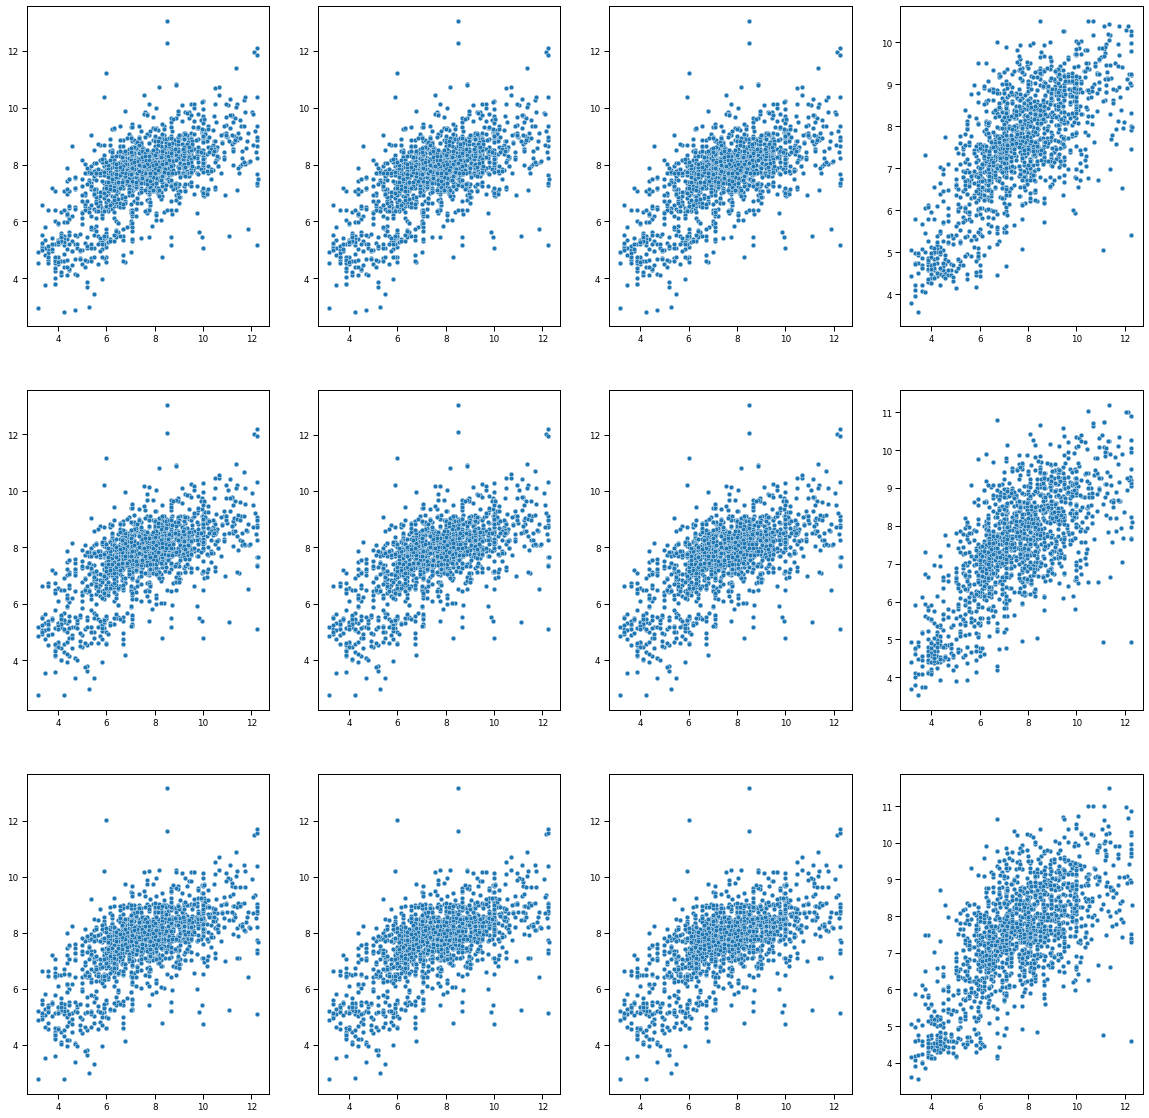

In [210]:
fig, ax = plt.subplots(3, 4, figsize=(20, 20))

sns.scatterplot(y_test_lasso, pred_lasso, ax=ax[0, 0])
sns.scatterplot(y_test_ridge, pred_ridge, ax=ax[0, 1])
sns.scatterplot(y_test_elasticnet, pred_elasticnet, ax=ax[0, 2])
sns.scatterplot(y_test_rf, pred_rf, ax=ax[0, 3])

sns.scatterplot(y_test_lasso_sel, pred_lasso_sel, ax=ax[1, 0])
sns.scatterplot(y_test_ridge_sel, pred_ridge_sel, ax=ax[1, 1])
sns.scatterplot(y_test_elasticnet_sel, pred_elasticnet_sel, ax=ax[1, 2])
sns.scatterplot(y_test_rf_sel, pred_rf_sel, ax=ax[1, 3])

sns.scatterplot(y_test_lasso_sel_supp, pred_lasso_sel_supp, ax=ax[2, 0])
sns.scatterplot(y_test_ridge_sel_supp, pred_ridge_sel_supp, ax=ax[2, 1])
sns.scatterplot(y_test_elasticnet_sel_supp, pred_elasticnet_sel_supp, ax=ax[2, 2])
sns.scatterplot(y_test_rf_sel_supp, pred_rf_sel_supp, ax=ax[2, 3])

# Summary

Fitting several regression models to different set of features, we find that: 

* Random Forest is the model that works the best, fitting the model to features selected by Random Forest feature importance. In this way we find a higher R square and a lower error compared to other set of features. 

* Although Lasso, Ridge and ElasticNet fit train and test data equally, we find that Random Forest fits training data best, yet fit for test data decreases considerable, but still showing a higher R square compared to other models.

* In the plots we can also see that the model with a lower error is Random Forest, as it approximates a diagonal line when comparing actual and predicted data, in comparison to Lasso, Ridge or ElasticNet, models with an equal performance between them.